## Table of Contents
- 1: Import 
- 2: Load Data
- 3: Pre-process Data
    - 1: Unify year notation
    - 2: Extract ethnicity
    - 3: Actor name and page link
    - 4: Add Wikidata ID, Rotten Tomatoes score and number of reviews
    - 5: Change dictionaries to list in dataframe
    - 6: Actor score with coreference resolution
    - 7: Masculinity and femininity score per summary with Empath library
    - 8: Gender Metric
    - 9: Create large ethnicity column
    - 10: Merge character and Movie DF
    - 11: Save preprocessed Dataframe

- 4: Simple analysis of movie metadata
    - 1: Number of movies/actors for which we have data in each category
    - 2: Ethnicity availability
    - 3: Combined analysis of Movies
    - 4: Combinatory analysis of character information
    - 5: Combined analysis of characters and movies
    - 6: Temporal analysis
    - 7: Rotten Tomatoes score    
    - 8: Simple ethnicity display for Men in Black and Pulp fiction
    - 9: Empath score of summary analysis
    - 10: Gender score analysis 
    - 11: Ethnicity score analysis
- 5: Temporal analysis
- 6: Distribution analysis
    - 1: Country distribution
    - 2: Movie genre distribution
    - 3: Yearly distribution of genre, ethnicity and country
- 7: Observational studies
    - 1: Exacting matchinf for observational studies on all the data
    - 2: Propensity score matching for a yearly observational study

# Introduction

We will guide you through our notebook where we have carried out all the data processing steps for our Applied Data Analysis project. First of all, we use the CMU Movie Summary Corpus, and we will try to manipulate it in order to study the question of representativeness in cinema. We have structured our notebook as follows:
We start by importing all the libraries we will use (part 1: Import), then we load the raw data from the dataset (part 2: Load data). Next, we do all the data processing we need (part 3: Pre-processing data). We start by cleaning the data, before adding data, processing it and doing our computations, such as adding our metrics. Afterwards, we make sure that these manipulations are correct and usable (part 4: Simple analysis of movie metadata).  We analyse the distribution of the dataset, we check that our calculations are correct and that we have enough data to conduct meaningful analyses. Finally, we devote ourselves to the visualisation of the calculations and analysis carried out (part 5: Temporal analysis and part 6: Distribution analysis), with interactive graphics for our website. Finally, we perform an Obeservationnal study (exact matching and propensity matching) using the collected data and the created metrics.

In order to simplify the collaboration between the group members and to greatly accelerate the computations, we have punctually saved our work in a separate folder (preprocessed data) that we load when necessary. 

[Disclaimer]
Please note, that we made some interactive plot for our website, thus not all plot are displayed correctly in this notebook. Please refer to our [website](https://nmuenger.github.io/2022_ada_datastory/) for correct display of the missing plots.

# 1. Import <a class="anchor" id="first-bullet"></a>

In [1]:
# Not the be run every time : Heavy
!pip install neuralcoref
!pip install spacy==2.3.1
!python -m spacy download en_core_web_sm

# Load SpaCy model 
import spacy
import neuralcoref
import en_core_web_sm

In [2]:
%%capture
!pip install mkwikidata;
!pip install "requests>=2.20.1";
!pip install "mwparserfromhell>=0.5.0";
!pip install empath
!pip install statsmodels
!pip install networkx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from dateutil.parser import parse
import pickle
import time 
from pathlib import Path
import mkwikidata
import requests
from empath import Empath
import itertools
from collections import Counter
import statsmodels.formula.api as smf
import networkx as nx
import ast
import re
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import datetime

In [3]:
DATA_FOLDER = 'movieData/'
movie_metadata_path = DATA_FOLDER+"movie.metadata.tsv"
character_metadata_path = DATA_FOLDER+"character.metadata.tsv"
name_clusters_path = DATA_FOLDER+"name.clusters.txt"
plot_summaries_path = DATA_FOLDER+"plot_summaries.txt"
tvtropes_clusters_path = DATA_FOLDER+"tvtropes.clusters.txt"
summaries_resolved_path = DATA_FOLDER+"final_sammuries_resolved.csv"

# 2. Load Data <a class="anchor" id="second-bullet"></a>

In [4]:
#load movies dataset
movieDF = pd.read_csv(movie_metadata_path, sep="\t", header=None, names=['Wikipedia Movie ID', 'Freebase movie ID', 'Movie name',
                    'Year','Box office revenue', 'Runtime', 'Language', 'Country', 'Genre'])
movieDF.head(5)

,Wikipedia Movie ID,Freebase movie ID,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
#load characters dataset
characterDF = pd.read_csv(character_metadata_path, sep="\t", header=None, names=['Wikipedia Movie ID', 'Freebase movie ID','Movie date', 'Character Name',
                    'DOB','Gender', 'Height', 'ethnicity ID', 'Actor name', 'Actor age at release','Freebase character map', 'unknown param1', 'Freebase wikidata actor page'])
characterDF

,Wikipedia Movie ID,Freebase movie ID,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,Freebase character map,unknown param1,Freebase wikidata actor page
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [6]:
#load plot_summuries data
summaryDF = pd.read_csv('movieData/plot_summaries.txt',sep='\t')
summaryDF.columns = ['Wikipedia Movie ID', 'Summary']
summaryDF.head()

,Wikipedia Movie ID,Summary
0,31186339,The nation of Panem consists of a wealthy Capi...
1,20663735,Poovalli Induchoodan is sentenced for six yea...
2,2231378,"The Lemon Drop Kid , a New York City swindler,..."
3,595909,Seventh-day Adventist Church pastor Michael Ch...
4,5272176,The president is on his way to give a speech. ...


# 3. Pre-processing Data

In this part, we perform all the calculations and cleaning necessary for our analyses. From the raw freebase or wikidata links, we extract the interpretable data. Then we enrich the dataset with the rottentomatoes score associated with the film. Furthermore, we perform a textual analysis of the summaries in order to associate a masculinity/femininity score with the lexical fields used.  We deal with the problem of character co-reference in the summaries in order to calculate a meaningful actor score. Finally, we create our two metrics that we will use in our analyses.

## 3.1 Unify year notation

Format of the year relase is variable and we unify it, keeping only the year of release

In [7]:
#Unify year notation
movieDF['Year']= movieDF['Year'].dropna().apply(lambda x: parse(x).year if(1887<parse(x).year<2018) else pd.NA)

## 3.2 Extract ethnicity

From the raw freebase ID (enncoded) associated to an ethnicity, we extract the ethnicity name (readable), with wikidata queries and add it to the character dataframe. Moreover, to speed up computations we save it for futur time.

In [8]:
#try to open ethnicity dictonnary from saved file, otherwise create it and load it
pathEthnicityDict, pathEthnicityDF = Path('processedData/myEthnicitydict.pickle'), Path('processedData/ethnicityDF.pkl')
if pathEthnicityDict.is_file() and pathEthnicityDF.is_file():
    myEthnicitydict = pickle.load(open(pathEthnicityDict, 'rb'))
    ethnicityDF = pd.read_pickle(pathEthnicityDF)
    ethnicityDF.columns = ethnicityDF.iloc[0]
    ethnicityDF = ethnicityDF[1:]
    loadedEthnicity = True
else :
    # Create ethnicity data frame with ethnicity freebase ID, ethnicity name, and number of actor per ethnicity
    ethnicityDF = pd.DataFrame(characterDF.groupby(by = ['ethnicity ID']).size()[characterDF.groupby(by = ['ethnicity ID']).size() > -1], columns=['Number'])
    ethnicityDF['Freebase ID'] = ethnicityDF.index
    ethnicityDict = {}
    loadedEthnicity = False

In [9]:
#Run a single query with (almost) all ethnicity from the freebase ID
if not loadedEthnicity :
    query = """
    SELECT ?item ?freebaseID ?name WHERE {
      ?item p:P646 [ps:P646 ?freebaseID]. #get the freebaseID
      ?item rdfs:label ?name.             #get the name of the enthnic group
      ?item p:P31 [ps:P31 wd:Q41710].     #get only the items whose "instance of" is "ethnic group"
      filter(lang(?name) = "en")          #get the names in english
    }
    """
    queryResult = mkwikidata.run_query(query, params={ })

    #Store the results in a dict for easy retrival
    ethnicityDict = {}
    for x in queryResult["results"]["bindings"]:
        ethnicityDict[x["freebaseID"]["value"]] = x["name"]["value"]

In [10]:
# Complete the dataset with the lacking ethnicity name, run multiple time until convergence 
if not loadedEthnicity :
    queryBase = """
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

    SELECT  ?s ?sLabel ?p  ?o ?oLabel WHERE {
     ?s wdt:P646 "TO REPLACE" 

       SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
       }
     }
    """

    failure, prevousFailure = 0, -1
    while (failure != previousFailure):
        failure = 0 
        for index, row in ethnicityDF.iterrows():
            if not row['Freebase ID'] in ethnicityDict:
                query = queryBase.replace('TO REPLACE', row['Freebase ID'])
                i = 0
                while(i < 5):
                    i+=1
                    try :
                        time.sleep(0.001) #to avoid to be block because of multiple successive request
                        query_result = mkwikidata.run_query(query, params={ })
                        data = [x["sLabel"]["value"] for x in query_result["results"]["bindings"]]
                        if(len(data)):
                            ethnicityDict[row['Freebase ID']] = data[0]
                            i = 6
                    except: pass
                if not row['Freebase ID'] in ethnicityDict:        
                    failure += 1

        print('How many time did we fail ? ', failure)
        previousFailure = failure
    
    #fill the missing values with Na's after we converged
    for index, row in ethnicityDF.iterrows():
        if not row['Freebase ID'] in ethnicityDict:
            ethnicityDict[row['Freebase ID']] = pd.NA

    #save the dictionnary
    with open('myEthnicitydict.pickle', 'wb') as file:
        pickle.dump(ethnicityDict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
#save the dictionnary and the ethnicity DF
if not loadedEthnicity :
    pickle.dump(ethnicityDict, open(pathEthnicityDict, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    ethnicityDF['Name'] = ethnicityDF['Freebase ID'].apply(lambda x : ethnicityDict[x]) #complete the DF with the found ethnicity
    ethnicityDF.sort_values(['Number'], ascending=False)
    ethnicityDF.to_pickle(pathEthnicityDF)

In [12]:
#Display ethnicty DF
ethnicityDF.Number = ethnicityDF.Number.apply(lambda x: int(x))
ethnicityDF = ethnicityDF.sort_values(by='Number',ascending=False)
ethnicityDF

ethnicity ID,Number,Freebase ID,Name
/m/0dryh9k,16351,/m/0dryh9k,Indians
/m/0x67,10159,/m/0x67,African Americans
/m/041rx,10121,/m/041rx,Jewish people
/m/02w7gg,6165,/m/02w7gg,English people
/m/033tf_,3857,/m/033tf_,Irish Americans
...,...,...,...
/m/0fp54b,1,/m/0fp54b,Koryo-saram
/m/032m0b,1,/m/032m0b,Chettiar
/m/0fpxlz9,1,/m/0fpxlz9,NaN
/m/01gr8h,1,/m/01gr8h,Sherpa


In [13]:
#Add Ethnicity name to characterDF based on ethnicityDF
characterDF['Ethnicity'] = pd.NA
characterDF['Ethnicity'] = characterDF['ethnicity ID'].dropna().apply(lambda x : ethnicityDF.loc[x].Name)
characterDF

,Wikipedia Movie ID,Freebase movie ID,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,Freebase character map,unknown param1,Freebase wikidata actor page,Ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


## 3.3 Actor name and page link

From a freebase link, we retrieve the actor name and url to the wikidata associated page. Since, the actor name is already available and we don't use the actor's page URL, we won't use it any further. We did this retrieval for the sake of completness of the analysis of our available data.

In [14]:
#extract one freebase link for actor name and page   
queryBase = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>

SELECT  ?s ?sLabel ?p  ?o ?oLabel WHERE {
    ?s wdt:P646 "TO REPLACE" 

    SERVICE wikibase:label {
    bd:serviceParam wikibase:language "en" .
    }
    }
"""

#extract third link of the dataframe
query = queryBase.replace('TO REPLACE', characterDF['Freebase wikidata actor page'][3])
#Run the query to wikidata
query_result = mkwikidata.run_query(query, params={ })
#Process and display the returned data 
data = [[x["sLabel"]["value"], x["s"]["value"]] for x in query_result["results"]["bindings"]]
print('Name : \"%s\", actor\'s URL to wikidata \"%s\"' %(data[0][0],data[0][1]))

Name : "Jason Statham", actor's URL to wikidata "http://www.wikidata.org/entity/Q169963"


We'll see further in this notebook that we already always have the actor's name, and the URL to the wikidata page, don't seem relevant to us. Thus we won't exploit any further this entry.

## 3.4 Add Wikidata ID, Rotten Tomatoes score and number of reviews

From the wikidata ID, we query the rottentomatoes score and number of reviews if available in order to enrich our data.

In [15]:
path_compl_data = Path('processedData/complementary_data.tsv')

#The file is already prepocessed but if not present, can redo the queries 
#(Redoing the queries takes an awful lot of time...)
if path_compl_data.is_file() :
    added_data = pd.read_csv(path_compl_data, sep="\t")
    loaded_added_data= True
else :
    # Create ethnicity data frame with ethnicity freebase ID, ethnicity name, and number of actor per ethnicity
    added_data = movieDF[['Wikipedia Movie ID']].copy()
    added_data['Wikidata movie ID'] = np.NaN
    added_data['Rotten Tomatoes score'] = np.NaN
    added_data['Number of reviews'] = np.NaN
    loaded_added_data = False


Query the wikidata ID from the wikipedia page ID

In [16]:
if not loaded_added_data : 
    !pip install "requests>=2.20.1"
    !pip install "mwparserfromhell>=0.5.0"
    !pip install pywikibot
    import pywikibot

In [17]:
if not loaded_added_data :    
    wikidata_list = list(pd.NA for i in range(len(added_data)))
    print('Length of dataframe :',len(added_data))

    for index, movie in added_data.iterrows():
        if (index % 1000) == 0: #To diplay progress
            print(index)
        #check for non Nan Wikipedia Movie ID
        if not pd.isna(movie['Wikipedia Movie ID']):
            wikipedia_ID = str(movie['Wikipedia Movie ID'])
            query = 'https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&pageids='+wikipedia_ID+'&format=json'
            r = requests.get(query)
            try:
                wikidata_ID = r.json()['query']['pages'][wikipedia_ID]['pageprops']['wikibase_item']
                wikidata_list[index]=wikidata_ID
            except:
                wikidata_list[index]=np.NaN
                pass
            
    added_data['Wikidata movie ID']=wikidata_list



Query the Rotten Tomatoes score from wikidata ID.
We first verify if the P444 exists, which correspond to the 'review score' section. If it does, we list the claim under P444, and check if P459 exist under it, which correspond to determination method. We want to retrieve only the value where this determination method is done by 'Tomatometer score' (Q108403393). If this category does indeed exist we take its value and we have the Rotten Tomatoes score of the movie


In [18]:
if not loaded_added_data :    
    rt_list = list(pd.NA for i in range(len(added_data)))
    print('Length of dataframe :',len(added_data))

    for index, movie in added_data.iterrows():
        if (index % 1000) == 0: #To diplay progress
            print(index)

        rt_list[index]=np.NaN
        #check for non Nan Wikidata movie ID
        if not pd.isna(movie['Wikidata movie ID']):
            wikipedia_ID = str(movie['Wikidata movie ID'])

            site = pywikibot.Site("wikidata", "wikidata")
            repo = site.data_repository()
            item = pywikibot.ItemPage(repo, wikipedia_ID) # Wikidata ID for 'Ghost of Mars' 
            item_dict = item.get() #Get the item dictionary
            clm_dict = item_dict["claims"] # Get the claim dictionary

            if 'P444' in clm_dict: #Check if review score exist
                for clm in clm_dict["P444"]: #P444 is property for 'review score'
                    if 'P459' in clm.qualifiers: #P459 is property for 'determination method'
                        for qual in clm.qualifiers['P459']: #iterate over all P459
                            if qual.toJSON()['datavalue']['value']['numeric-id'] == 108403393: #Q108403393 is the Wikidata ID for 'Tomatometer score'
                                try: #In case there is any other problem
                                    RT_score = clm.getTarget()
                                    rt_list[index] = int(RT_score.replace('%','')) #Change score to int and take off the %
                                except:
                                    pass

    added_data['Rotten Tomatoes score']=rt_list


Query number of reviews given from wikidata ID

In [19]:
if not loaded_added_data : 
    nb_review_list = list(pd.NA for i in range(len(added_data)))
    print('Length of dataframe :',len(added_data))

    for index, movie in added_data.iterrows():
        if (index % 1000) == 0: #To diplay progress
            print(index)

        nb_review_list[index]=np.NaN
        #check for non Nan Wikidata movie ID
        if not pd.isna(movie['Rotten Tomatoes score']): #Number of reviews will only be available when RT score exists
            wikipedia_ID = str(movie['Wikidata movie ID'])

            site = pywikibot.Site("wikidata", "wikidata")
            repo = site.data_repository()
            item = pywikibot.ItemPage(repo, wikipedia_ID) 
            item_dict = item.get() #Get the item dictionary
            clm_dict = item_dict["claims"] # Get the claim dictionary

            if 'P444' in clm_dict: #Check if review score exist
                for clm in clm_dict["P444"]: #P444 is property for 'review score'
                    if 'P7887' in clm.qualifiers: #P7787 is property for 'number of reviews/ratings'
                        for qual in clm.qualifiers['P7887']: #iterate over all P7787
                            try: #In case there is any other problem
                                number_reviews=qual.toJSON()['datavalue']['value']['amount']
                                nb_review_list[index] = int(number_reviews)
                            except:
                                pass 
                             
    added_data['Number of reviews']=nb_review_list

Merge the new queried data to original dataframe.

In [20]:
movieDF = movieDF.merge(added_data, on = ['Wikipedia Movie ID'])
movieDF[['Wikidata movie ID','Rotten Tomatoes score','Number of reviews']].head()

,Wikidata movie ID,Rotten Tomatoes score,Number of reviews
0,Q261700,22.0,108.0
1,Q16250726,NaN,NaN
2,Q4978832,NaN,NaN
3,Q7995657,50.0,8.0
4,Q869644,NaN,NaN


## 3.5 Change dictionaries to list in dataframe


For convinience we change 'Language', 'Country', and 'Genre' from dictionnary to list

In [21]:
movieDF['Language'] = movieDF.Language.apply(lambda d: list(json.loads(d).values()))
movieDF['Country'] = movieDF.Country.apply(lambda d:list(json.loads(d).values()))
movieDF['Genre'] = movieDF.Genre.apply(lambda d: list(json.loads(d).values()))
movieDF.head()

,Wikipedia Movie ID,Freebase movie ID,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre,Wikidata movie ID,Rotten Tomatoes score,Number of reviews
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Q261700,22.0,108.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",Q16250726,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",Q4978832,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",Q7995657,50.0,8.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],Q869644,NaN,NaN


## 3.6 Actor score with coreference resolution

In order to conduct our analysis, we need to ascociated an actor score to each character of a film. This actor score should reflect how important the character is in the movie. We did that by analysing the summaries and count how offten and in which order the character are cited.

We start by solving the problem of character co-reference in summaries. The problem to be solved is the following, based on the text: 

    Harry is a wizard, he finds out that he is enrolled in Hogwarts, a mysterious school of magic, when he receives a letter addressed to Mr. Potter. 

We have to find the references to Harry Potter (_Harry, he, Mr. Potter_). To do this, we use NLP tools: **spacy** and **neuralcoref**, to replace each reference with the name of the character, before counting them and constructing our score.

We construct the actor score as follows:

- Each character starts with 2 points (we will perform a logarithm and we did not want to have the case log(1) = 0).

- We then give additional points each time a character is referenced in the summary. 1 point if it is the last reference in the text, two points if it is the second last, etc.

- We calculate the actor score for each character as follows: $ \frac{log(number of points)}{total points} $, in order to have :
    1. $actor score \in [0,1]$
    2. $\sum actor score = 1$

In [22]:
# Please uncomment if the corref has to be run and cannot be loaded
# use neural coref to do coreference resolution
#nlp = en_core_web_sm.load()
#neuralcoref.add_to_pipe(nlp)
#example
#doc = nlp(u'My sister has a dog. She loves him.')
#doc._.has_coref
#doc._.coref_clusters
#doc._.coref_resolved


In [23]:
#Apply Coref resolution to the whole dataset and return the resolved text : DONT RUN THIS , IT WAS RUN LOCALLY
#summaryDF['Summary']=summaryDF['Summary'].apply(lambda x : nlp(x)._.coref_resolved)

#save dataframe
#summaryDF.to_csv('final_summaries_resolved', sep='\t')

#load resolved sammuries
summaryresolDF = pd.read_csv('movieData/final_sammuries_resolved.csv',sep='\t')

In [24]:
#useful method to compute actor score : reverse the text
def reverse_text(text):
    # Split the text into words
    words = text.split()
    # Reverse the list of words
    words = words[::-1]
    # Join the reversed list of words into a string
    reversed_text = " ".join(words)
    return reversed_text

In [25]:
def actor_score(caracters_list,text):
    #Remove special characters from text
    text = re.sub(r'[^a-zA-Z0-9\s]',' ',text)
    #reverse the text to add points 
    text= reverse_text(text)
    # initialize each character with 1 point since we take the log in the end 
    points = {name: 1 for name in caracters_list}  
    # split the text into words and iterate over them
    score=2
    # keep track of the the word before as we are looping over words so that we dont count Harry Potter two times
    previous_word='-'
    for word in text.split():
     # if the word is a character's name, increment their points
             for character in caracters_list:
                if (word in character) & (len(word)>1) & (previous_word not in character):
                    
                    index = caracters_list.index(character)
                    points[caracters_list[index]]=points[caracters_list[index]]+score
                    score+=1
             previous_word=word    

    # add 1 to characters that don't appear in the sammury
    for word in caracters_list:
        if points[word]==1:
            points[word]+=1
        
    # compute the sum of the logs of the values in the dictionary
    sum_of_logs = sum([np.log(value) for key, value in points.items()])

    # calculate the proportion of points for each character
    proportions = {name: np.log(points[name]) / sum_of_logs for name in caracters_list}
    return proportions


In [26]:
#drop rows with character name Nan and keep only 'Wikipedia Movie ID', 'Character Name' columns
characterlistDF=characterDF[characterDF['Character Name'].notna()]
characterlistDF = characterlistDF[['Wikipedia Movie ID', 'Character Name']]
# group by wikipedia movie id to get list of characters per film
characterlistDF = characterlistDF.groupby('Wikipedia Movie ID')['Character Name'].apply(list).reset_index(name='caractersList')
#merge the resolved summaries with list of characters per film
summaryresolDF = summaryresolDF.rename(columns={'Wikipedia movie ID': 'Wikipedia Movie ID'})
scoreDF=pd.merge(characterlistDF, summaryresolDF, on='Wikipedia Movie ID')
#apply actor score which return dictionary that maps each character to his actor score
scoreDF['Proportions']= scoreDF.apply(lambda x: actor_score(x.caractersList,x.Summary) ,axis=1)
#merge characterDF with scoreDF
caracterScoreDF = pd.merge(scoreDF, characterDF[characterDF['Character Name'].notna()], on='Wikipedia Movie ID')
# affect each caracter to his score from the dictionary proportions
def get_score(row):
    scores = row['Proportions']
    character_name = row['Character Name']
    return scores[character_name]
#get the score of each character from the dictionary
caracterScoreDF['actor score'] = caracterScoreDF.apply(lambda x : get_score(x), axis=1)



In [27]:
#merge the original caracterDF dataframe with caracterScoreDF and fill nan values with 0
merged_df = pd.merge(characterDF, caracterScoreDF[['Character Name', 'actor score','Wikipedia Movie ID']], on =['Character Name','Wikipedia Movie ID'], how='left')
merged_df['actor score'].fillna(0, inplace=True)
merged_df=merged_df.drop_duplicates()

In [28]:
characterDF=merged_df
characterDF.head()

,Wikipedia Movie ID,Freebase movie ID,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,Freebase character map,unknown param1,Freebase wikidata actor page,Ethnicity,actor score
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,0.014749
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,0.131413
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,0.119824
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,0.102909
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,0.125070


## 3.7 Masculinity and femininity score per summary with Empath library

We use the tool for analysing the lexical fields of a text: empath in order to assign a masculinity and femininity score to the summaries.

In [29]:
lexicon = Empath()
#for every summary get masculanity score
summaryDF['masculanity score'] = summaryDF.apply(lambda row: list (lexicon.analyze(row['Summary'], categories=["masculine"],normalize=True).values())[0], axis = 1)
#for every summary get femininity score
summaryDF['femininity score'] = summaryDF.apply(lambda row: list ( lexicon.analyze(row['Summary'], categories=["feminine"],normalize=True).values() )[0], axis = 1)

## 3.8 Gender Metric

In order to analyse gender diversity in films, we need a metric to quantify it. We construct it in the following way.

$g \in [0,1]$ : the gender score asociated to a movie $i$

Number of male actor in movie i : $m_i$  
Number of female actress in movie i : $f_i$  
Ratio of female vs total number of actor in movie i : $r_i : \in [0,1]$    
  
Cummulated importance of male actor in movie i : $mp_i$  
Cummulated importance of female actress in movie i : $fp_i$    
Ratio of cumulated importance of female actress vs total roles importance $rp_i$  

Masculinity of speech in summary of movie i : $ms_i$  
Feminility of speech in summary of movie i : $fs_i$    
  
$ r_i \in [0,1]$ : maximum gender diversity is at $0.5$  
$ (1 - 2\cdot r_i) \in [-1,1]$ : maximum gender diversity is at $0$   
$ |(1 - 2\cdot r_i)| \in [0,1] $ : maximum gender diversity is at $0$  
$ 1 - |(1 - 2\cdot r_i)| \in [0,1]$ : maximum gender diversity is at $1$  
This part pounder gender score by proportion of gender represented  
  
$ rp_i \in [0,1]$ : maximum gender diversity is at $0.5$  /  
$ (1 - 2\cdot rp_i) \in [-1,1]$ : maximum gender diversity is at $0$  /   
$ |(1 - 2\cdot rp_i)| \in [0,1] $ : maximum gender diversity is at $0$  \\ /    
$ 1 - |(1 - 2\cdot rp_i)| \in [0,1]$ : maximum gender diversity is at $1$ /\\   
This part pounder gender score by relative importance of the role they play 

$ fs_i - ms_i $ : maximum diversity is at $0$ /  
$ |fs_i - ms_i| $ : maximum diversity is at $0$ \\/   
$ 1 - |fs_i - ms_i| $ : maximum diversity is at $1$ /\\    
This part pounder gender score by the empath score of the summary
  
$ g = (1 - |(1 - 2\cdot r_i)|) \cdot (1 - |(1 - 2\cdot rp_i)|) \cdot (1 - |fs_i - ms_i|)  $  

In [30]:
def genderScore(wikipediaMovieID):

    #temp variable to increase computation speed (x40)
    movieTemp = characterDF.loc[characterDF['Wikipedia Movie ID'] == wikipediaMovieID]

    # get the number of actor and the number of actor in that movie whom we know the gender
    nbActor, nbGender = movieTemp.count()[['Wikipedia Movie ID', 'Gender']]
    
    if(not nbActor > 0 ):
        return np.nan
    
    fracOfGenderKnownInMovie = nbGender/nbActor
    
    # Compute score only if we its relevant ie-> we have enough availble data
    if(fracOfGenderKnownInMovie > 0.8):
        
        nbActorPerGenderArray = movieTemp['Gender'].dropna().value_counts()

        if(np.size(nbActorPerGenderArray) < 2): #ie, only one gender represented
            ratioFemale = 0
        else :
            ratioFemale = (nbActorPerGenderArray['F'])/(nbActorPerGenderArray['F'] + nbActorPerGenderArray['M'])
        
        # compute cumulated actor score for each gender, then compute ratio. 
        cumulatedFemaleActorScore = movieTemp[movieTemp['Gender'] == 'F']['actor score'].dropna().sum()
        cumulatedMaleActorScore = movieTemp[movieTemp['Gender'] == 'M']['actor score'].dropna().sum()
        ratioFemaleCumulatedImportance = (cumulatedFemaleActorScore) / (cumulatedFemaleActorScore + cumulatedMaleActorScore)

        # retrieve empath score if available
        femininEmpath, masculinEmpath = [0,0]
        summaryTemp = summaryDF.loc[summaryDF['Wikipedia Movie ID'] == wikipediaMovieID]
        if(len(summaryTemp) > 0) :
            femininEmpath = summaryTemp['femininity score'].values[0]
            masculinEmpath = summaryTemp['masculanity score'].values[0]


        # compute gender score with intermediate variables
        return (1 - abs(1 - 2*ratioFemale)) * (1 - abs(1 - 2*ratioFemaleCumulatedImportance)) * (1 - abs(femininEmpath - masculinEmpath))
    
    # not concluant
    return np.nan

In [31]:
#try to open ethnicity dictonnary from saved file, otherwise create it and load it
pathGenderDiversityDF = Path('processedData/gender_diversity.csv')
loadedGenderDiversityDF = False
if pathGenderDiversityDF.is_file() :
    genderDiversityDF = pd.read_csv(pathGenderDiversityDF, sep=",", header=None, names=['Wikipedia Movie ID', 'gender_diversity'])
    genderDiversityDF = genderDiversityDF[0:]
    genderDiversityDF['Wikipedia Movie ID'] = genderDiversityDF['Wikipedia Movie ID'].apply(lambda x:int(x))
    genderDiversityDF['gender_diversity'] = genderDiversityDF['gender_diversity'].apply(lambda x:float(x))
    loadedGenderDiversityDF = True

In [32]:
if not loadedGenderDiversityDF:
    # Compute Gender score per movei and add it to the movie DF, it takes around 10 min to run
    movieDF['gender_diversity'] = movieDF['Wikipedia Movie ID'].apply(lambda x : genderScore(x))
else :
    movieDF = movieDF.merge(genderDiversityDF, how='inner', on=['Wikipedia Movie ID'], sort=False, suffixes=('_x', '_y'))

In [33]:
if not loadedGenderDiversityDF :
    # saving the dataframe
    movieDF[['Wikipedia Movie ID','gender_diversity']].to_csv('processedData/gender_diversity.csv')

In [34]:
movieDF[['Wikipedia Movie ID', 'gender_diversity']]

,Wikipedia Movie ID,gender_diversity
0,975900,0.578766
1,3196793,NaN
2,28463795,NaN
3,9363483,NaN
4,261236,NaN
...,...,...
81736,35228177,NaN
81737,34980460,NaN
81738,9971909,NaN
81739,913762,0.332624


## 3.8 Create large ethnicity column

The dataset contains more than 450 ethnicities, which is unrepresentable, difficult to manipulate and impractical for a meaningful analysis. We have therefore grouped these ethnicities into more general categories, based on essentially geographical criteria (with the exception of North American and Afro-American, which is not a geographical distinction). We add a large ethnicity column to our dataframe.

In [35]:
# load dictionnary to asociate exact ethnicity to a more generic yet practicable category
# reading the data from the file
with open('processedData/LargeEthnicityDict.txt',encoding="utf8") as f:
    largeEthnicityRaw = f.read()
      
# reconstructing the data as a dictionary
largeEthnicityDict = ast.literal_eval(largeEthnicityRaw)

In [36]:
# Create new columns 'large ethnicity' to the characterDF
characterDF['Large ethnicity'] = characterDF['Ethnicity'].dropna().apply(lambda x : largeEthnicityDict.get(x,np.nan))

## 3.9 Ethnicity Metric

In order to analyse ethnic diversity in films, we need a metric to quantify it. We construct it in the following way.

#### ethnicity score :
ethnicity score : $ s \in [0,1]$   
number of ethnicity in a movie $i$ : $e_i$  
number of actor in a movie $i$ : $a_i$  
ethnicity particular score : $p \in [0,1]$


$ \frac{e_i}{min(e_{tot}, a_i)} \quad$  : This term account for number of ethnicity represented  (linear in number) in a movie $\in [0,1]$  
  
  
$\sum p_j\quad$ : This termn account for ethnicity relative importance. The more an ethnicity is represented, the less representative value it has. $\in [0,1]$  

   
$\sum (min(p_j - |\sum r_{jki} - p_j|,0)) \quad$ : This term account for minority visibility in main roles.


  
$ s_i = \frac{ \frac{e_i}{min(e_{tot}, a_I)} + \sum p_j+ \sum (max(p_j - |\sum r_{jki} - p_j|,0))} { 3 }$  

#### ethnicity particluar score :
$ p_j \in [0,1] $, $p_j$ is the largest for ethnicity that are the least represented.  
$a_j$  : number of roles/characters of a specific ethnicity (in the whole dataset)  
$r_jk$ : Importance of the role k  
  
$p_j = \frac {\frac{1}{ln(a_j)}}{\Sigma \frac{1}{ln(a_l)}} \quad <=> \quad p_j = \frac{1}{ln(a_j) \cdot \Sigma \frac{1}{ln(a_l)}}$

Thus we have : $p_j \in [0,1]$ and  $\Sigma p_j = 1$


#### Importance of actor role
$r_{ki}$ : Importance of the role k in the movie i  
$\sum r_{jki}$ : Cumulated importance of the roles played by acotors of ethnicity j in the movie i 
$\sum r_{jki} - p_j$ : Maximum ponderation for specific ethnicity at $0$  /  
$|\sum r_{jki} - p_j|$ : Maximum ponderation for specific ethnicity at $0$  \\ /    
$p_j - |\sum r_{jki} - p_j|$ : Maximum ponderation for specific ethnicity at $p_j$  / \\   
$max(p_j - |\sum r_{jki} - p_j|,0)$ : Maximum ponderation for specific ethnicity at $p_j$  / \\  



In [37]:
#try to open ethnicity dictonnary from saved file, otherwise create it and load it
pathEthnicityDiversityDF = Path('processedData/ethnicity_diversity.csv')
loadedEthnicityDiversityDF = False
if pathEthnicityDiversityDF.is_file() :
    ethnicityDiversityDF = pd.read_csv(pathEthnicityDiversityDF, sep=",", header=None, names=['Wikipedia Movie ID', 'ethnicity_diversity'])
    ethnicityDiversityDF = ethnicityDiversityDF[0:]
    ethnicityDiversityDF['Wikipedia Movie ID'] = ethnicityDiversityDF['Wikipedia Movie ID'].apply(lambda x:int(x))
    ethnicityDiversityDF['ethnicity_diversity'] = ethnicityDiversityDF['ethnicity_diversity'].apply(lambda x:float(x))
    loadedEthnicityDiversityDF = True

In [38]:
if not loadedEthnicityDiversityDF :
    # get param for ethnicity score computation
    # compute overall parameter
    normalisation = sum(1/np.log(characterDF.groupby(by = 'Large ethnicity')['Large ethnicity'].count()))
    largeEthnicityScoreDict = dict( 1 / (np.log(characterDF.groupby(by = 'Large ethnicity')['Large ethnicity'].count()) * normalisation) )

In [39]:
def ethnicityScore(wikipediaMovieID):
    #temp variable to increase computation speed (x40)
    movieTemp = characterDF.loc[characterDF['Wikipedia Movie ID'] == wikipediaMovieID]

    # get the number of actor in that movie
    nbActor = movieTemp.count()['Wikipedia Movie ID']

    # Compute metric only if we have valid data
    if(not nbActor > 0 ):
        return np.nan

    # get the number of actor in that movie whom we know the large ethnicity
    nbLargeActEthnicity = movieTemp.count()['Large ethnicity']
    
    fracOfEthnicityKnownInMovie = nbLargeActEthnicity/nbActor
    
    # Compute score only if we its relevant ie-> we have enough availble data
    if(fracOfEthnicityKnownInMovie > 0.5):

        nbDiffEthn = len(movieTemp['Large ethnicity'].dropna().unique())
        
        sumSpecificEthnicityScore = 0
        sumSpecificActorScore = 0
        actorTemp = movieTemp.groupby(by='Large ethnicity').sum()['actor score']
        for value in movieTemp['Large ethnicity'].dropna().unique():
            sumSpecificEthnicityScore += largeEthnicityScoreDict[value]
            sumSpecificActorScore += max(largeEthnicityScoreDict[value] - abs(actorTemp[value] - largeEthnicityScoreDict[value]), 0)

        return ( (nbDiffEthn/min(nbLargeActEthnicity,10)) + (sumSpecificEthnicityScore) + (sumSpecificActorScore) ) / 3
    
    # not concluant
    return np.nan

In [40]:
# Add the ethnicity diversity score to the Movie DF
if not loadedEthnicityDiversityDF :
    # Create new columns 'ethnicity score' to the characterDF and compute it (run in ~3 min)
    movieDF['ethnicity_diversity'] = movieDF['Wikipedia Movie ID'].dropna().apply(lambda x : ethnicityScore(x))
else :
    movieDF = movieDF.merge(ethnicityDiversityDF, how='inner', on=['Wikipedia Movie ID'], sort=False, suffixes=('_x', '_y'))

In [41]:
if not loadedEthnicityDiversityDF :
    # saving the dataframe
    movieDF[['Wikipedia Movie ID','ethnicity_diversity']].to_csv('processedData/ethnicity_diversity.csv')

In [42]:
movieDF[['Wikipedia Movie ID', 'ethnicity_diversity']]

,Wikipedia Movie ID,ethnicity_diversity
0,975900,NaN
1,3196793,NaN
2,28463795,NaN
3,9363483,NaN
4,261236,NaN
...,...,...
81736,35228177,NaN
81737,34980460,NaN
81738,9971909,NaN
81739,913762,NaN


## 3.10 Merge character and Movie DF

We merge the movie and character data frame in order to conduct further analysis in combined features.

In [43]:
mergedcharacterDF = characterDF.merge(movieDF, how='inner', on=['Wikipedia Movie ID'], sort=False, suffixes=('_x', '_y'))

## 3.11 Save preprocessed Dataframe 

In [44]:
movieDF.to_csv('processedData/preprocessedMovieDF.csv')
characterDF.to_csv('processedData/preprocessedCharacterDF.csv')

# 4. Simple analysis of movie metadata

Now that the dataset has been preprocessed, we want to verify if it is crisp enough to be analyzed.
We will check how many values we have for every aspect of the data. And we will analyze the distribution of the empath score, the gender metric and the ethnicity metric. 

## 4.1 Number of movies/actors for which we have data in each category

In [45]:
print('Number of movies for which we have data in that category\n')
print(movieDF.count())

print('Propotion of movies for which we have data in that category\n')
print(movieDF.count()/movieDF.count().max()*100)

Number of movies for which we have data in that category

Wikipedia Movie ID       81741
Freebase movie ID        81741
Movie name               81741
Year                     74838
Box office revenue        8401
Runtime                  61291
Language                 81741
Country                  81741
Genre                    81741
Wikidata movie ID        76927
Rotten Tomatoes score    14990
Number of reviews        14990
gender_diversity         20270
ethnicity_diversity       9511
dtype: int64
Propotion of movies for which we have data in that category

Wikipedia Movie ID       100.000000
Freebase movie ID        100.000000
Movie name               100.000000
Year                      91.555034
Box office revenue        10.277584
Runtime                   74.981955
Language                 100.000000
Country                  100.000000
Genre                    100.000000
Wikidata movie ID         94.110667
Rotten Tomatoes score     18.338410
Number of reviews         18.338410
ge

<AxesSubplot: title={'center': 'Movies for which we have data in that particular category'}, ylabel='Percentage out of total number of movies'>

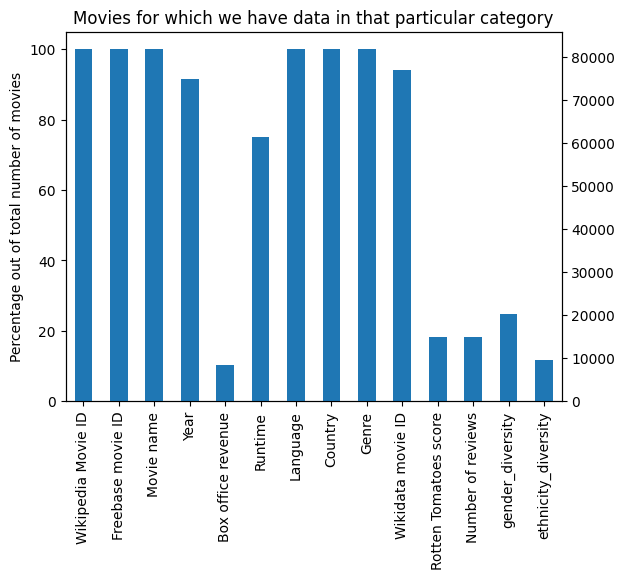

In [46]:
movieDF.count().plot(kind='bar', secondary_y=True)
(movieDF.count()/movieDF.count().max()*100).plot(kind='bar', ylabel='Percentage out of total number of movies', title='Movies for which we have data in that particular category')

In [47]:
print('Number of movies for which we have data in that category\n')
print(characterDF.count())

print('Propotion of movies for which we have data in that category\n')
print(characterDF.count()/characterDF.count().max()*100)

Number of movies for which we have data in that category

Wikipedia Movie ID              450669
Freebase movie ID               450669
Movie date                      440674
Character Name                  192794
DOB                             344524
Gender                          405060
Height                          154824
ethnicity ID                    106058
Actor name                      449441
Actor age at release            292556
Freebase character map          450669
unknown param1                  192804
Freebase wikidata actor page    449854
Ethnicity                       102876
actor score                     450669
Large ethnicity                 101995
dtype: int64
Propotion of movies for which we have data in that category

Wikipedia Movie ID              100.000000
Freebase movie ID               100.000000
Movie date                       97.782186
Character Name                   42.779512
DOB                              76.447237
Gender                       

<AxesSubplot: title={'center': 'Proportion of actors for which we have data in that particular category'}, ylabel='Percentage of total number of actors'>

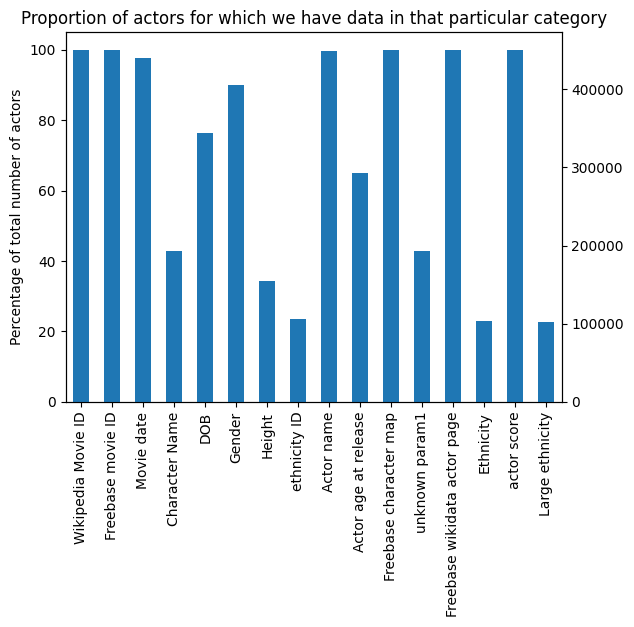

In [48]:
characterDF.count().plot(kind='bar', secondary_y=True)
(characterDF.count()/characterDF.count().max()*100).plot(kind='bar', ylabel='Percentage of total number of actors', title='Proportion of actors for which we have data in that particular category')

## 4.2 Ethnicity availability

In [49]:
print('We retrieved ethnicity names for %.2f%% of the ethnicity ID\'s' %(100*ethnicityDF.dropna()['Number'].astype(int).sum()/ ethnicityDF['Number'].astype(int).sum()))
print('This means we know the ethnicity name for %d actor entries' %(ethnicityDF.dropna()['Number'].astype(int).sum()))

We retrieved ethnicity names for 97.00% of the ethnicity ID's
This means we know the ethnicity name for 102876 actor entries


## 4.3 Combined analysis of Movies

<AxesSubplot: >

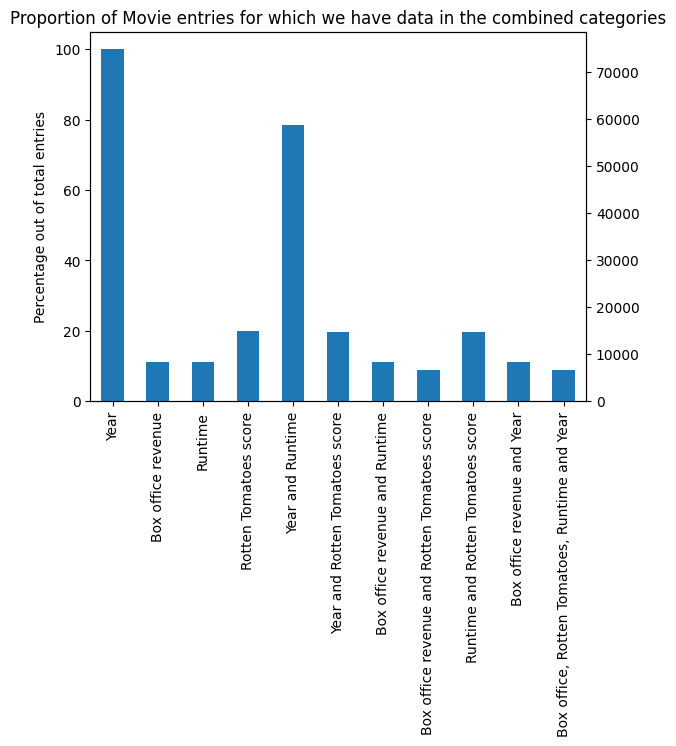

In [50]:
movieStat = pd.DataFrame(data = {'Year' : [movieDF.groupby(by = ['Year']).size().sum()],
                                 'Box office revenue' : [movieDF.groupby(by = ['Box office revenue']).size().sum()],
                                 'Runtime' : [movieDF.groupby(by = ['Box office revenue']).size().sum()],
                                 'Rotten Tomatoes score' : [movieDF.groupby(by = ['Rotten Tomatoes score']).size().sum()],
                                 'Year and Runtime' : [movieDF.groupby(by = ['Year', 'Runtime']).size().sum()],
                                 'Year and Rotten Tomatoes score' : [movieDF.groupby(by = ['Year', 'Rotten Tomatoes score']).size().sum()],
                                 'Box office revenue and Runtime' : [movieDF.groupby(by = ['Box office revenue', 'Runtime']).size().sum()],
                                 'Box office revenue and Rotten Tomatoes score' : [movieDF.groupby(by = ['Box office revenue', 'Rotten Tomatoes score']).size().sum()],
                                 'Runtime and Rotten Tomatoes score' : [movieDF.groupby(by = ['Runtime', 'Rotten Tomatoes score']).size().sum()],
                                 'Box office revenue and Year' : [movieDF.groupby(by = ['Box office revenue', 'Year']).size().sum()],
                                 'Box office, Rotten Tomatoes, Runtime and Year' : [movieDF.groupby(by = ['Box office revenue', 'Rotten Tomatoes score', 'Year', 'Runtime']).size().sum()],
                                 
                                })
movieStat.head()

#characterStat.plot.bar() #two kind of plot
(movieStat.squeeze()/movieStat.squeeze().max()*100).plot(kind='bar')
(movieStat.squeeze()).plot(kind='bar', ylabel='Percentage out of total entries', title='Proportion of Movie entries for which we have data in the combined categories', secondary_y=True)

## 4.4 Combinatory analysis of character information

<AxesSubplot: >

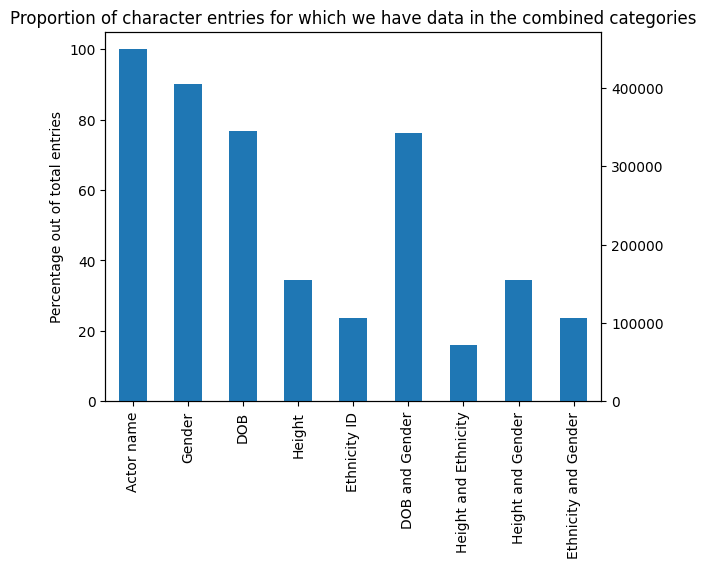

In [51]:
characterStat = pd.DataFrame(data = {'Actor name' : [characterDF.groupby(by = ['Actor name']).size().sum()],
                                     'Gender' : [characterDF.groupby(by = ['Gender']).size().sum()],
                                     'DOB' : [characterDF.groupby(by = ['DOB']).size().sum()],
                                     'Height' : [characterDF.groupby(by = ['Height']).size().sum()],
                                     'Ethnicity ID' : [characterDF.groupby(by = ['ethnicity ID']).size().sum()],
                                     'DOB and Gender' : [characterDF.groupby(by = ['DOB','Gender']).size().sum()],
                                     'Height and Ethnicity' : [characterDF.groupby(by = ['ethnicity ID', 'Height']).size().sum()],
                                     'Height and Gender' : [characterDF.groupby(by = ['Height', 'Gender']).size().sum()],
                                     'Ethnicity and Gender' : [characterDF.groupby(by = ['ethnicity ID', 'Gender']).size().sum()],
                                     })
characterStat.head()

#characterStat.plot.bar() #two kind of plot
(characterStat.squeeze()/characterStat.squeeze().max()*100).plot(kind='bar')
(characterStat.squeeze()).plot(kind='bar', ylabel='Percentage out of total entries', title='Proportion of character entries for which we have data in the combined categories', secondary_y=True)

## 4.5 Combined analysis of characters and movies

In [52]:
mergedcharacterDF.head()

,Wikipedia Movie ID,Freebase movie ID_x,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,...,Box office revenue,Runtime,Language,Country,Genre,Wikidata movie ID,Rotten Tomatoes score,Number of reviews,gender_diversity,ethnicity_diversity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Q261700,22.0,108.0,0.578766,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Q261700,22.0,108.0,0.578766,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Q261700,22.0,108.0,0.578766,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Q261700,22.0,108.0,0.578766,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Q261700,22.0,108.0,0.578766,NaN


<AxesSubplot: >

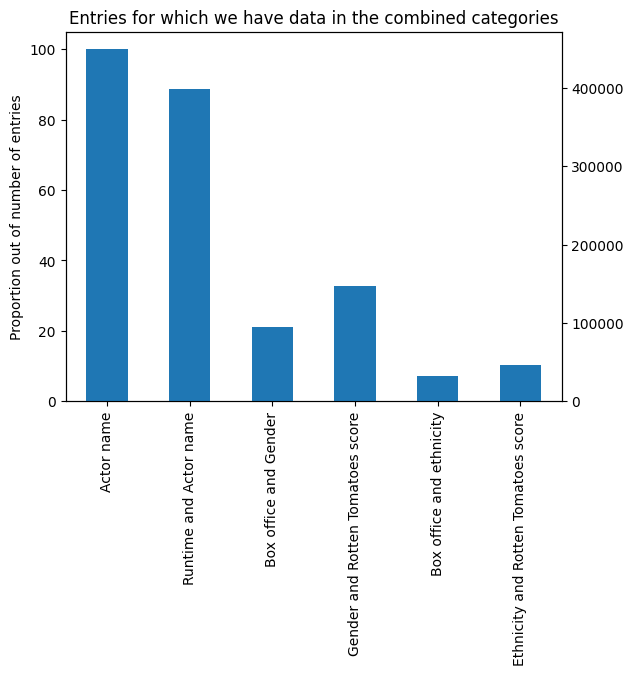

In [53]:
mergedStat = pd.DataFrame(data = {'Actor name' : [mergedcharacterDF.groupby(by = ['Actor name']).size().sum()],
                                  'Runtime and Actor name' : [mergedcharacterDF.groupby(by = ['Runtime', 'Actor name']).size().sum()],
                                  'Box office and Gender' : [mergedcharacterDF.groupby(by = ['Box office revenue','Gender']).size().sum()],
                                  'Gender and Rotten Tomatoes score' : [mergedcharacterDF.groupby(by = ['Gender', 'Rotten Tomatoes score']).size().sum()],
                                  'Box office and ethnicity' : [mergedcharacterDF.groupby(by = ['Box office revenue','ethnicity ID']).size().sum()],
                                  'Ethnicity and Rotten Tomatoes score' : [mergedcharacterDF.groupby(by = ['ethnicity ID', 'Rotten Tomatoes score']).size().sum()],
                                 })
mergedStat.head()

#characterStat.plot.bar() #two kind of plot
(mergedStat.squeeze()/mergedStat.squeeze().max()*100).plot(kind='bar')
(mergedStat.squeeze()).plot(kind='bar', ylabel='Proportion out of number of entries', title='Entries for which we have data in the combined categories', secondary_y=True)

## 4.6 Temporal analysis

<AxesSubplot: title={'center': 'Number of movies thoughout the years'}, xlabel='Year', ylabel='numbers of movies'>

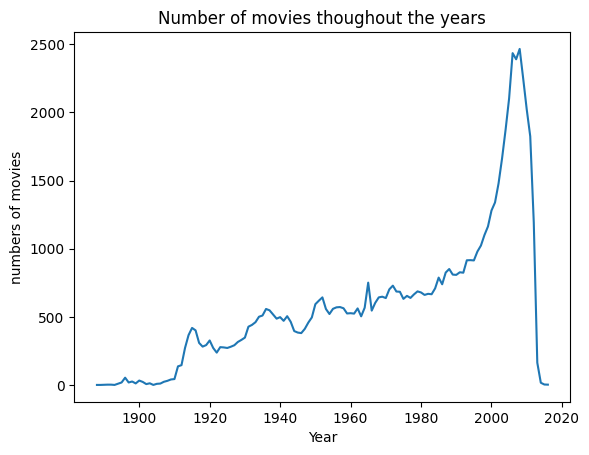

In [54]:
movies_per_year = movieDF.groupby(by=['Year'],  sort=True, dropna=True).size()
movies_per_year.plot(title='Number of movies thoughout the years', ylabel='numbers of movies')

A certain amount of category were omitted for the sake of visibility. Worth to notice, all the categories that we always have, such as _Country, Language, Genre, Freebase movie ID, Wikipedia Movie ID_ were ommited since the curve superpose with the highest one.

<AxesSubplot: title={'center': 'Evolution over time of the amount of entries for the features of the movie dataset'}, xlabel='Year', ylabel='Number of entries'>

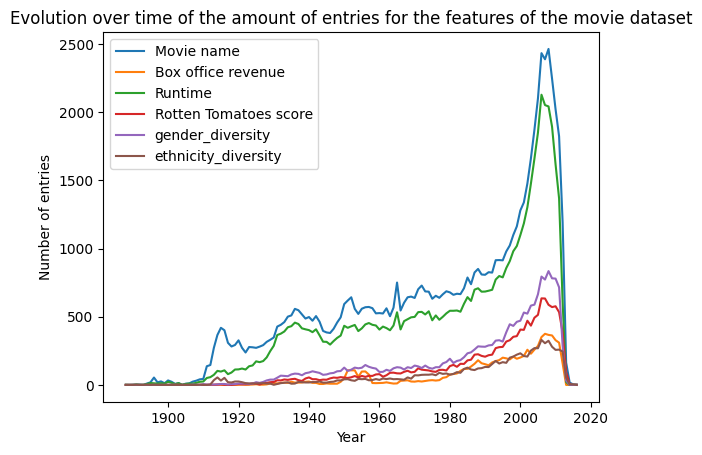

In [55]:
movieDF.groupby(by=['Year']).count().drop(columns=['Freebase movie ID','Wikipedia Movie ID','Wikidata movie ID','Genre','Country','Language','Number of reviews']).plot(title='Evolution over time of the amount of entries for the features of the movie dataset', ylabel='Number of entries')

<AxesSubplot: title={'center': 'Evolution over time of the amount of entries for the features of the character dataset'}, xlabel='Year', ylabel='Number of entries'>

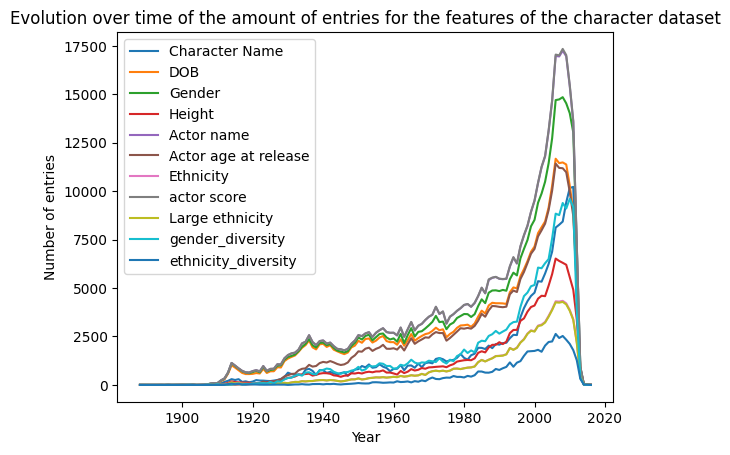

In [56]:
mergedcharacterDF.groupby(by=['Year']).count().drop(columns=['Freebase movie ID_x','Freebase movie ID_y', 'ethnicity ID','Freebase character map','unknown param1','Wikidata movie ID', 'Wikipedia Movie ID', 'Movie date','Genre','Country','Language','Runtime','Number of reviews','Rotten Tomatoes score','Box office revenue','Freebase wikidata actor page', 'Movie name']).plot(title='Evolution over time of the amount of entries for the features of the character dataset', ylabel='Number of entries')

## 4.7 Rotten Tomatoes score

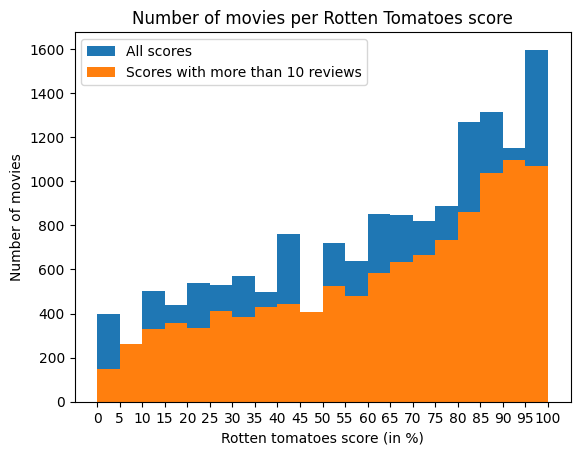

In [57]:
plt.hist(movieDF[(~movieDF['Rotten Tomatoes score'].isnull() )]['Rotten Tomatoes score'], bins = 20, label='All scores')
plt.hist(movieDF[movieDF['Number of reviews']>10]['Rotten Tomatoes score'], bins = 20,label='Scores with more than 10 reviews')
plt.xlabel('Rotten tomatoes score (in %)')
plt.ylabel('Number of movies')
plt.title('Number of movies per Rotten Tomatoes score')
plt.legend(loc='upper left')
plt.grid(False)
plt.xticks(np.arange(0,105,5))
plt.show()

In [58]:
print('There is', len(movieDF),' movies in the original dataset.')
print('Of those,',len(movieDF[(~movieDF['Rotten Tomatoes score'].isnull() )]),'have a Rotten Tomatoes score.')
print('Furthermore,', len(movieDF[movieDF['Number of reviews']>=10]), 'of those movies were reviewed by at least 10 critics.')
print('This represents',len(movieDF[movieDF['Number of reviews']>=10])/len(movieDF)*100,'%% of the data.')

There is 81741  movies in the original dataset.
Of those, 14990 have a Rotten Tomatoes score.
Furthermore, 11619 of those movies were reviewed by at least 10 critics.
This represents 14.214408925753293 %% of the data.


## 4.8 Simple ethnicity display for Men in Black and Pulp fiction

In [59]:
((mergedcharacterDF.set_index('Wikidata movie ID')).loc['Q51416']).loc[:,['Actor name','Ethnicity']].dropna()

,Actor name,Ethnicity
Wikidata movie ID,,
Q51416,David Cross,British Americans
Q51416,Danny DeVito,Italian Americans
Q51416,Steven Spielberg,Jewish people
Q51416,Sylvester Stallone,Italian Americans
Q51416,George Lucas,white people
Q51416,Al Roker,Bahamian Americans
Q51416,Tony Shalhoub,Arab Americans
Q51416,Will Smith,African Americans


In [60]:
#Ethnicity for actor's in pulp fiction
((mergedcharacterDF.set_index('Wikidata movie ID')).loc['Q104123']).loc[:,['Actor name','Ethnicity']].dropna()

,Actor name,Ethnicity
Wikidata movie ID,,
Q104123,Rosanna Arquette,American Jews
Q104123,John Travolta,Italian Americans
Q104123,Samuel L. Jackson,African Americans
Q104123,Tim Roth,English people
Q104123,Ving Rhames,African Americans
Q104123,Phil LaMarr,African Americans
Q104123,Maria de Medeiros,Portuguese
Q104123,Uma Thurman,Swedish Americans
Q104123,Paul Calderon,Stateside Puerto Ricans


## 4.9 Empath score of summary analysis

In [61]:
summaryDF['masculanity score'].describe()

count    42302.000000
mean         0.002400
std          0.005720
min          0.000000
25%          0.000000
50%          0.000000
75%          0.002347
max          0.086957
Name: masculanity score, dtype: float64

In [62]:
summaryDF['femininity score'].describe()

count    42302.000000
mean         0.002684
std          0.006107
min          0.000000
25%          0.000000
50%          0.000000
75%          0.002786
max          0.086957
Name: femininity score, dtype: float64

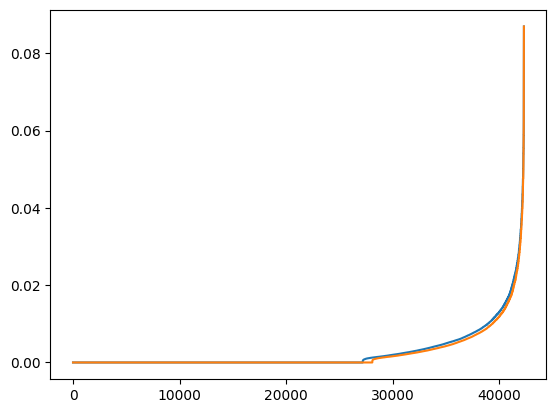

In [63]:
#Plot of ordered feminity and masculanity score
plt.plot(summaryDF['femininity score'].sort_values().reset_index(drop=True))
plt.plot(summaryDF['masculanity score'].sort_values().reset_index(drop=True))
plt.show()

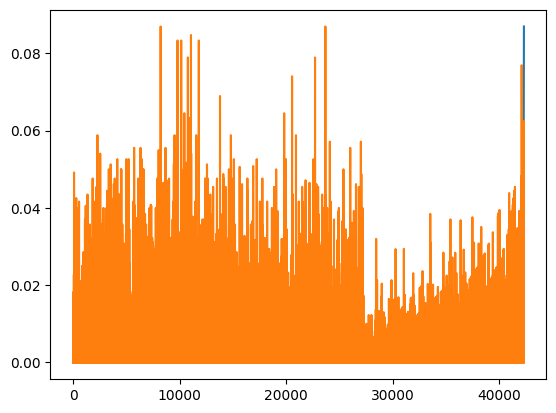

In [64]:
#Plot of feminity and masculanity score ordered only with feminie score
plt.plot(summaryDF[['femininity score','masculanity score']].sort_values(by = 'femininity score').reset_index(drop=True)['femininity score'])
plt.plot(summaryDF[['femininity score','masculanity score']].sort_values(by = 'femininity score').reset_index(drop=True)['masculanity score'])
plt.show()

In [65]:
summaryDF.head()

,Wikipedia Movie ID,Summary,masculanity score,femininity score
0,31186339,The nation of Panem consists of a wealthy Capi...,0.002571,0.002571
1,20663735,Poovalli Induchoodan is sentenced for six yea...,0.000000,0.002016
2,2231378,"The Lemon Drop Kid , a New York City swindler,...",0.000000,0.004711
3,595909,Seventh-day Adventist Church pastor Michael Ch...,0.000000,0.007557
4,5272176,The president is on his way to give a speech. ...,0.008721,0.000000


In [66]:
# Simple analysis of empath entries
print('original dataset has %d entry' %(len(summaryDF)))
print('Feminile non zero dataset has %d entry' %(len(summaryDF[summaryDF['femininity score'] > 0.001].sort_values(by = 'femininity score'))))
print('Masculine non zero dataset has %d entry' %(len(summaryDF[summaryDF['masculanity score'] > 0.001].sort_values(by = 'femininity score'))))
print('Feminile and Masculine non zero dataset has %d entry' %(len(summaryDF[(summaryDF['femininity score'] > 0.001) & (summaryDF['masculanity score'] > 0.001)])))

original dataset has 42302 entry
Feminile non zero dataset has 14775 entry
Masculine non zero dataset has 13873 entry
Feminile and Masculine non zero dataset has 6490 entry


## 4.10 Gender score analysis

<AxesSubplot: >

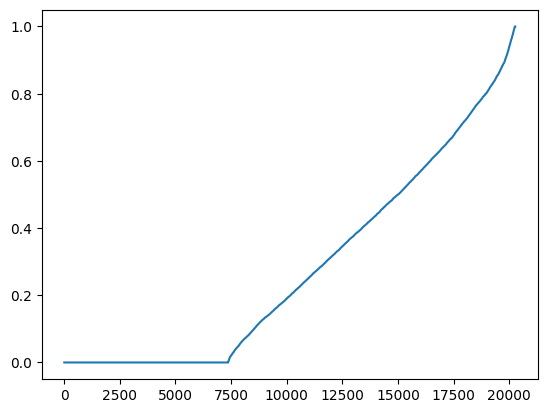

In [67]:
movieDF['gender_diversity'].dropna().sort_values().reset_index(drop=True).plot()

## 4.11 Ethnicity score analysis

In [68]:
# Check the 10 newly created category for the large ethnicity
characterDF['Large ethnicity'].unique()

array([nan, 'african american', 'near eastian', 'north american',
       'european', 'south asian', 'asian', 'south american', 'african',
       'pacific islander', 'other'], dtype=object)

<AxesSubplot: >

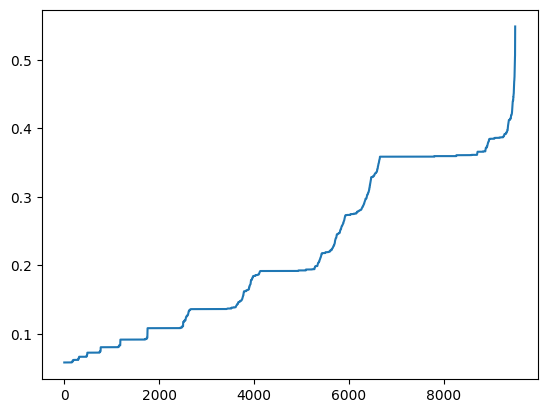

In [69]:
movieDF['ethnicity_diversity'].dropna().sort_values().reset_index(drop=True).plot()

# 5. Temporal analysis

The idea of this section is to analyze the evolution of the gender and ethnicitymetric through time. 

To do so, we first start by loading the preprocessed dataset, saved previously in the notebook.
Then we compute the average of our metrics (gender and ethnicity) for every year and made a nice plot to be saved in HTML. 

In [70]:
#Load preprocessed character dataset
preprocessedCharacterDF = pd.read_csv('processedData/preprocessedCharacterDF.csv')
#Unify year notation
preprocessedCharacterDF['Year']= preprocessedCharacterDF['Movie date'].dropna().apply(lambda x: parse(x).year if(1887<parse(x).year<2018) else pd.NA)
preprocessedCharacterDF.head()

,Unnamed: 0,Wikipedia Movie ID,Freebase movie ID,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,Freebase character map,unknown param1,Freebase wikidata actor page,Ethnicity,actor score,Large ethnicity,Year
0,0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,0.014749,NaN,2001
1,1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,0.131413,NaN,2001
2,2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,0.119824,african american,2001
3,3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,0.102909,NaN,2001
4,4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,0.125070,NaN,2001


In [71]:
#load preprocessed movies dataset
preprocessedDF_allyears = pd.read_csv('processedData/preprocessedMovieDF.csv')
preprocessedDF_allyears['Country'] = preprocessedDF_allyears.Country.apply(lambda d: json.loads(d.replace('\'', '\"')))
preprocessedDF_allyears['Genre'] = preprocessedDF_allyears.Genre.apply(lambda d: json.loads(d.replace("hildren's","hildrens").replace('\'', '\"')))
#Consider only movies released after 1940 (not enough data before that)
preprocessedDF = preprocessedDF_allyears[preprocessedDF_allyears.Year>=1940]
preprocessedDF.head(5)

,Unnamed: 0,Wikipedia Movie ID,Freebase movie ID,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre,Wikidata movie ID,Rotten Tomatoes score,Number of reviews,gender_diversity,ethnicity_diversity
0,0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Q261700,22.0,108.0,0.578766,NaN
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,['English Language'],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",Q16250726,NaN,NaN,NaN,NaN
2,2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,['Norwegian Language'],[Norway],"[Crime Fiction, Drama]",Q4978832,NaN,NaN,NaN,NaN
3,3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,['English Language'],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",Q7995657,50.0,8.0,NaN,NaN
4,4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,['German Language'],[Germany],[Drama],Q869644,NaN,NaN,NaN,NaN


In [72]:
grouped_by_year = preprocessedDF[preprocessedDF['Year']<=2012].groupby('Year').agg({'gender_diversity':['mean', 'count'],'ethnicity_diversity':['mean', 'count']}).reset_index()#mean().reset_index()

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(grouped_by_year['Year']), y=list(grouped_by_year['gender_diversity']['mean']), 
                name="Gender score",
                text=list(grouped_by_year['gender_diversity']['count']),
                hovertemplate="<br>".join([  
                                        "%{y:.3f}",
                                        "Number of films: %{text}"
                                        ])))
fig.add_trace(
    go.Scatter(x=list(grouped_by_year['Year']), y=list(grouped_by_year['ethnicity_diversity']['mean']), 
                name="Ethnicity score" ,
                text=list(grouped_by_year['ethnicity_diversity']['count']),
                hovertemplate="<br>".join([  
                                        "%{y:.3f}",
                                        "Number of films: %{text}"
                                        ])))

# Set title
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Score",
    margin={"t":0}
)

fig.update_layout(hovermode="x unified")
fig.update_layout(xaxis_hoverformat='%Y')

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(count=20,
                     label="20y",
                     step="year",
                     stepmode="backward"),
                dict(count=50,
                     label="50y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


fig.show()
fig.write_html("Plots/temporal_evolution.html")

# 6. Distribution analysis

## 6.1 Country distribution

We generate a dataframe with a row for everay country which appear in the original dataframe. We then compute the average ethnicity/gender score for each country by taking the mean of movies produced by said country. We only keep values when we have more than 10 movies produced for one country, otherwise a very little number of films can impact the score. 
We then plot these score on a globe.

In [73]:
flat_array_country = list(itertools.chain.from_iterable(preprocessedDF.Country.tolist()))
list_of_countries = np.unique(flat_array_country)
list_of_countries[0:5]

array(['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia'],
      dtype='<U40')

In [74]:
country_df = pd.DataFrame (list_of_countries, columns = ['country'])
country_df['Average gender score']=np.NaN
country_df['Gender nb of films']=np.NaN
country_df['Average ethnicity score']=np.NaN
country_df['Ethnicity nb of films']=np.NaN
country_df.head(3)

,country,Average gender score,Gender nb of films,Average ethnicity score,Ethnicity nb of films
0,Afghanistan,NaN,NaN,NaN,NaN
1,Albania,NaN,NaN,NaN,NaN
2,Algeria,NaN,NaN,NaN,NaN


In [75]:
for i in range(len(country_df)): #Fore every independant country
    cur_country= country_df['country'].loc[i]
    country_appear = preprocessedDF['Country'].apply(lambda x: any([cur_country in x]))
    
    nb_film_available_gender=preprocessedDF[country_appear]['gender_diversity'].count()
    if nb_film_available_gender >=10:
        country_df['Gender nb of films'].loc[i]=nb_film_available_gender
        country_df['Average gender score'].loc[i] = preprocessedDF[country_appear]['gender_diversity'].mean()
    
    nb_film_available_ethnicity=preprocessedDF[country_appear]['ethnicity_diversity'].count()
    if nb_film_available_ethnicity >=10:
        country_df['Ethnicity nb of films'].loc[i] = nb_film_available_ethnicity
        country_df['Average ethnicity score'].loc[i] = preprocessedDF[country_appear]['ethnicity_diversity'].mean()
    
    
country_df.head()

/tmp/ipykernel_1629/3282417563.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1629/3282417563.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1629/3282417563.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1629/3282417563.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

,country,Average gender score,Gender nb of films,Average ethnicity score,Ethnicity nb of films
0,Afghanistan,NaN,NaN,NaN,NaN
1,Albania,NaN,NaN,NaN,NaN
2,Algeria,NaN,NaN,NaN,NaN
3,Argentina,0.310634,39.0,0.315425,15.0
4,Armenia,NaN,NaN,NaN,NaN


In [76]:
filtered_country_df = country_df.dropna(subset=['Gender nb of films', 'Ethnicity nb of films'], how='all')
#Showing the country which 'cause problems' historically speaking. We want to map values from Soviet Union to
#Russia and values from West Germany to Germany. Yugoslavia is taken of the datafram
filtered_country_df[(filtered_country_df.country =='Russia')  | \
                    (filtered_country_df.country =='Germany')  | \
                    (filtered_country_df.country =='Soviet Union')  | \
                    (filtered_country_df.country =='West Germany') |\
                    (filtered_country_df.country =='Yugoslavia')]

,country,Average gender score,Gender nb of films,Average ethnicity score,Ethnicity nb of films
45,Germany,0.356480,672.0,0.251351,179.0
105,Russia,0.289889,41.0,NaN,NaN
117,Soviet Union,0.277302,39.0,0.324444,14.0
139,West Germany,0.162558,71.0,0.340032,18.0
140,Yugoslavia,0.089506,18.0,NaN,NaN


In [77]:
# A bit of ugly hardcoding but it's only for two rows so easier to do
filtered_country_df = country_df.dropna(subset=['Gender nb of films', 'Ethnicity nb of films'], how='all')

#Computing  pondered average (Hardcoding as its only for two lines)
russia_gender_score= (0.28988860407240397 * 41 + 0.27730245869994313 * 39) / (41+39)
russia_ethnicity_score= 0.3244435176899026 #Only values for Soviet union

germany_gender_score= (0.3564803763308183*672 + 0.16255845010277362 * 71) / (672+71)
germany_ethnicity_score = (0.3400316626753144 * 18 + 0.2513513765698375 * 179)/(18+179)

filtered_country_df.loc[filtered_country_df.country == 'Russia','Average gender score'] = russia_gender_score
filtered_country_df.loc[filtered_country_df.country == 'Russia','Average ethnicity score'] = russia_ethnicity_score

filtered_country_df.loc[filtered_country_df.country == 'Russia',['Gender nb of films','Ethnicity nb of films']] = \
    [80,14]

filtered_country_df.loc[filtered_country_df.country == 'Germany','Average gender score'] = germany_gender_score
filtered_country_df.loc[filtered_country_df.country == 'Germany','Average ethnicity score'] = germany_ethnicity_score

filtered_country_df.loc[filtered_country_df.country == 'Germany',['Gender nb of films','Ethnicity nb of films']] = \
    [743,197]
                                                                           
#Remove 'old countries
filtered_country_df = filtered_country_df[(filtered_country_df.country !='Soviet Union')  & \
                                            (filtered_country_df.country !='West Germany') &\
                                            (filtered_country_df.country !='Yugoslavia')]


In [78]:
cols_dd = ['Average gender score','Average ethnicity score']
visible = np.array(cols_dd)
traces = []
buttons = []

for value in cols_dd:
    if value == 'Average gender score':
        nb_films = filtered_country_df['Gender nb of films']
    else:
        nb_films = filtered_country_df['Ethnicity nb of films']
        
    traces.append(go.Choropleth(
       locations=filtered_country_df['country'], # Spatial coordinates
        z = filtered_country_df[value].astype(float), # Data to be color-coded
        text = nb_films,
        colorbar_title=value,
        locationmode="country names",
        visible= True if value==cols_dd[0] else False,
        name="",
        hovertemplate="<br>".join([ "Country: %{location}", 
                                    "Score: %{z:.3f}",
                                    "Number of films: %{text}"
                                        ])))

    buttons.append(dict(label=value,
                        method="update",
                        args=[{"visible":list(visible==value)}]))


updatemenus = [{"active":0,
                "buttons":buttons,
                "x":0.42,
                "xanchor":"left",
                "y":1.1,
                "yanchor":"top"
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))


fig.update_geos(projection_type="orthographic")
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.data[0].colorbar.x=-0.1
fig.data[1].colorbar.x=-0.1
fig.show()

fig.write_html("Plots/world_metric.html")

## 6.2 Movie genre distribution
In this part we evaluate the distribution of the two metrics by movie genres. For comprehensibility purposes we only evaluate the 12 more preent movie genres in the dataset. For each of these genres we compute the average scores of all movies that fall under this category.
We then display these results as a bar plot with the gender and ethnicity diversity score.

In [79]:
#Main genres found in section 7
main_genres= ['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Action', 'Thriller', 'Short Film', 'World cinema', 'Crime Fiction', 'Indie', 'Documentary', 'Horror']

In [80]:
movie_genre_df = pd.DataFrame (main_genres, columns = ['genre'])
movie_genre_df['Average gender score']=np.NaN
movie_genre_df['Gender CI Low']=np.NaN
movie_genre_df['Gender CI Top']=np.NaN
movie_genre_df['Average ethnicity score']=np.NaN
movie_genre_df['Ethnicity CI Low']=np.NaN
movie_genre_df['Ethnicity CI Top']=np.NaN


for i in range(len(movie_genre_df)): #For every main movie genre
    cur_genre= movie_genre_df['genre'].loc[i]
    genre_appear = preprocessedDF['Genre'].apply(lambda x: any([cur_genre in x]))
    
    movie_genre_df['Average gender score'].loc[i] = preprocessedDF[genre_appear]['gender_diversity'].mean()
    movie_genre_df['Average ethnicity score'].loc[i] = preprocessedDF[genre_appear]['ethnicity_diversity'].mean()

    gender_diversity_score = (preprocessedDF[genre_appear]['gender_diversity'].dropna(), )
    gender_CI_low, gender_CI_top = stats.bootstrap(gender_diversity_score, n_resamples=1000, statistic=np.mean, confidence_level=0.95, method='percentile').confidence_interval
    movie_genre_df['Gender CI Low'].loc[i] = movie_genre_df['Average gender score'].loc[i] - gender_CI_low
    movie_genre_df['Gender CI Top'].loc[i] = gender_CI_top - movie_genre_df['Average gender score'].loc[i]

    ethnicity_diversity_score = (preprocessedDF[genre_appear]['ethnicity_diversity'].dropna(), )
    ethnicity_CI_low, ethnicity_CI_top = stats.bootstrap(ethnicity_diversity_score, n_resamples=1000, statistic=np.mean, confidence_level=0.95, method='percentile').confidence_interval
    movie_genre_df['Ethnicity CI Low'].loc[i] = movie_genre_df['Average ethnicity score'].loc[i] - ethnicity_CI_low
    movie_genre_df['Ethnicity CI Top'].loc[i] = ethnicity_CI_top - movie_genre_df['Average ethnicity score'].loc[i]
    
movie_genre_df.head()

/tmp/ipykernel_1629/191526762.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1629/191526762.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1629/191526762.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1629/191526762.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

,genre,Average gender score,Gender CI Low,Gender CI Top,Average ethnicity score,Ethnicity CI Low,Ethnicity CI Top
0,Drama,0.319364,0.005614,0.005911,0.187362,0.003422,0.003278
1,Comedy,0.316900,0.007694,0.007760,0.215087,0.004965,0.004791
2,Romance Film,0.397181,0.009372,0.009521,0.167806,0.004847,0.004895
3,Black-and-white,0.161850,0.018586,0.018476,0.291980,0.017129,0.016934
4,Action,0.215770,0.007962,0.008502,0.183774,0.005209,0.005872


In [81]:
fig = go.Figure()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=main_genres,
    y= movie_genre_df['Average gender score'].to_list(),
    name='Average gender score',
    error_y=dict(
            type='data',
            symmetric=False,
            array=movie_genre_df['Gender CI Top'].to_list(),
            arrayminus=movie_genre_df['Gender CI Low'].to_list()),
    marker_color='#646ffb'
))
fig.add_trace(go.Bar(
    x=main_genres,
    y=movie_genre_df['Average ethnicity score'].to_list(),
    name='Average ethnicity score',
    error_y=dict(
            type='data',
            symmetric=False,
            array=movie_genre_df['Ethnicity CI Top'].to_list(),
            arrayminus=movie_genre_df['Ethnicity CI Low'].to_list()),
    marker_color='#eb543d'
))


# Add dropdown
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Both",
                     method="update",
                     args=[{"visible": [True, True]},
                           {"title": "Both",
                            }]),
                dict(label="Gender score",
                     method="update",
                     args=[{"visible": [True, False]},
                           {"title": "Gender score",
                            }]),
                dict(label="Ethnicity score",
                     method="update",
                     args=[{"visible": [False, True]},
                           {"title": "Ethnicity score",
                            }]),
            ]),
        ),
    ])



# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    yaxis_title="Score"
)
fig.update_layout(showlegend=True)
fig.update_layout(xaxis_type='category', 
                    bargap=0.2,
                    xaxis = dict(
                        tickfont=dict(family='Helvetica', size=14, color='black')
                    ))
       
fig.update_layout(legend=dict(x=-0.35,y=0.9))
fig.show()
fig.write_html("Plots/movie_genre_distribution.html")

## 6.3 Yearly distribution of genre, ethnicity and country

In this section, we will compute meaningful yearly statistics for the genre, country and ethnicity distribution, thus enabling to easily visualise shift in distribution of the dataset over the years. Then we'll do an interactive plot to be save in HTML.

In [82]:
#Create dataframe with number of movie by year and genre
# It is then normalise in percentage
# note that we use a moving avergae with a time span of 5 year
yearly_genre_df = pd.DataFrame (main_genres, columns = ['genre'])
year_span = 73

for i in range(year_span):
    year = str(1940+i)
    yearly_genre_df[year]=np.NaN

# Compute moving average of number of film per year per genre
for i in range(len(yearly_genre_df)): #Fore every independant country
    cur_genre= yearly_genre_df['genre'].loc[i]
    genre_appear = preprocessedDF['Genre'].apply(lambda x: any([cur_genre in x]))
    for j in range(year_span):
        year = 1940+j
        yearly_genre_df[str(year)].loc[i] = preprocessedDF[(preprocessedDF['Year']>=year-2) & (preprocessedDF['Year']<=year+2)]['Genre'].apply(lambda x: any([cur_genre in x])).sum()

# Normalise number of film to percentage
for i in range(year_span):
    year = 1940+i
    yearly_genre_df[str(year)] = 100 * (yearly_genre_df[str(year)] / yearly_genre_df[str(year)].sum())
    
yearly_genre_df.head(10)

/tmp/ipykernel_1629/856406111.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,genre,1940,1941,1942,1943,1944,1945,1946,1947,1948,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Drama,21.100129,20.594059,20.998896,20.980847,22.117718,24.168798,26.480836,27.809755,28.725212,...,25.115763,24.608436,24.352248,24.163550,24.178451,24.574258,25.872588,26.850404,27.903509,29.480537
1,Comedy,15.513537,15.049505,14.983444,14.451538,13.288835,12.851662,12.733608,12.571948,12.861190,...,13.728559,13.480378,13.036188,12.722242,12.447720,12.193643,11.608861,11.167579,10.631579,10.216554
2,Romance Film,7.950150,7.590759,8.002208,7.980267,7.858010,7.800512,8.203991,8.179340,8.073654,...,9.411074,8.998651,8.638503,8.438797,8.325035,8.196473,8.492277,9.023977,9.201754,9.724990
3,Black-and-white,26.772669,26.930693,26.241722,24.869414,23.604369,22.506394,20.335762,19.872766,19.745042,...,0.202178,0.199449,0.173095,0.122970,0.109540,0.080853,0.043973,0.045609,0.043860,0.026571
4,Action,6.102278,6.204620,6.070640,5.861869,5.643204,4.699488,4.276212,4.089670,3.909348,...,6.861019,6.452748,6.209769,6.276579,6.338379,6.756279,7.557852,8.620016,9.482456,10.801116
5,Thriller,4.125483,3.861386,4.111479,4.585026,5.248786,5.914322,6.715236,6.573766,5.949008,...,8.008870,8.177392,8.416725,8.551519,8.932484,9.328415,9.751003,10.190253,10.789474,11.080112
6,Short Film,8.637731,9.933993,9.740618,10.504933,10.740291,9.814578,8.425721,7.906695,7.422096,...,3.991391,4.012436,3.959539,3.847927,3.764190,3.688918,3.699225,3.661715,3.657895,3.587086
7,World cinema,0.085948,0.297030,0.386313,0.609402,0.910194,1.182864,1.267026,1.423811,1.529745,...,10.487185,10.512114,10.158490,10.022032,9.788887,9.313255,8.129500,7.258275,6.280702,4.291218
8,Crime Fiction,5.758487,4.950495,4.856512,4.730122,5.157767,6.138107,7.475451,7.936989,8.555241,...,4.950108,4.728105,4.478823,4.242455,4.391555,4.497448,4.633650,4.691165,4.929825,4.875781
9,Indie,0.042974,0.066007,0.082781,0.087057,0.060680,0.063939,0.126703,0.151469,0.226629,...,6.274049,6.658063,7.086060,7.347441,7.344155,6.978624,5.985819,4.919208,3.929825,2.803242


In [83]:
#Create dataframe with number of movie by year and country
# It is then normalise in percentage
# note that we use a moving avergae with a time span of 5 year
yearly_country_df = pd.DataFrame (list_of_countries, columns = ['country'])
year_span = 73

# Add year columns to the dataframe
for i in range(year_span):
    year = str(1940+i)
    yearly_country_df[year]=np.NaN

# Compute moving average of number of film per year per country
for i in range(len(country_df)): #Fore every independant country
    cur_country= yearly_country_df['country'].loc[i]
    country_appear = preprocessedDF['Country'].apply(lambda x: any([cur_country in x]))
    
    for j in range(year_span):
        year = 1940 + j
        yearly_country_df[str(year)].loc[i] = preprocessedDF[country_appear]['Year'].loc[preprocessedDF[country_appear]['Year'] == year].count()
        
# Normalise number of film to percentage
for i in range(year_span):
    year = 1940+i
    yearly_country_df[str(year)] = 100 * (yearly_country_df[str(year)] / yearly_country_df[str(year)].sum())

# Keep only the 8 most relevant country
sorted_yearly_country_df = yearly_country_df.sort_values(by = '2000',ascending = False).head(8)
otherNB = list(100-sorted_yearly_country_df.sum().values[1:])
otherNB.insert(0,'Rest of the world')
sorted_yearly_country_df.loc[len(sorted_yearly_country_df)] = otherNB
sorted_yearly_country_df

/tmp/ipykernel_1629/969019104.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,1940,1941,1942,1943,1944,1945,1946,1947,1948,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
132,United States of America,58.943089,67.602592,69.135802,65.864333,71.059432,68.518519,63.947368,56.385542,55.506608,...,33.137543,32.931034,35.537849,39.004871,38.069609,35.485009,34.877489,32.672811,33.971292,32.771693
53,India,4.878049,3.455724,2.469136,3.063457,2.325581,3.439153,3.421053,3.855422,4.405286,...,11.160059,9.956897,10.557769,10.090466,10.728382,14.179894,12.251149,12.534562,10.765550,23.588880
131,United Kingdom,13.414634,9.287257,7.613169,10.940919,9.302326,8.730159,8.947368,11.807229,15.418502,...,7.929515,7.844828,7.888446,7.098121,7.140294,7.054674,7.350689,7.096774,7.535885,7.076664
41,France,1.219512,1.079914,1.851852,1.750547,0.516796,1.587302,2.631579,3.855422,1.762115,...,5.090553,5.344828,4.701195,4.279749,4.305705,4.585538,5.589587,5.898618,5.442584,4.380792
22,Canada,0.203252,0.431965,0.411523,0.437637,0.258398,0.000000,0.000000,0.963855,0.000000,...,5.531082,4.827586,4.780876,4.871260,5.453893,4.938272,5.359877,4.976959,4.425837,2.443134
45,Germany,2.642276,2.807775,1.646091,2.188184,1.550388,0.529101,0.526316,1.204819,0.660793,...,4.650024,4.827586,4.342629,3.688239,2.834589,3.527337,3.560490,3.271889,3.708134,2.695872
63,Japan,0.000000,0.647948,0.411523,1.312910,0.516796,0.793651,1.052632,0.963855,0.440529,...,3.573177,4.396552,4.103586,3.653445,2.726947,2.680776,2.833078,2.258065,2.631579,3.201348
61,Italy,1.016260,1.295896,3.292181,1.531729,1.033592,1.587302,2.631579,2.891566,3.524229,...,1.566324,1.767241,1.434263,1.183020,1.255831,1.128748,1.263400,1.382488,1.375598,1.263690
8,Rest of the world,17.682927,13.390929,13.168724,12.910284,13.436693,14.814815,16.842105,18.072289,18.281938,...,27.361723,28.103448,26.653386,26.130828,27.484751,26.419753,26.914242,29.907834,30.143541,22.577928


In [84]:
#Create dataframe with number of actor by year and ethnicity
# It is then normalise in percentage
# note that we use a moving avergae with a time span of 5 year
#Liste of large ethnicity
main_ethnicity= ['north american', 'african american', 'south american', 'european', 'african', 'near eastian', 'asian', 'south asian', 'pacific islander', 'other']
yearly_ethnicity_df = pd.DataFrame (main_ethnicity, columns = ['ethnicity'])
year_span = 73

for i in range(year_span):
    year = str(1940+i)
    yearly_ethnicity_df[year]=np.NaN

# Compute moving average of number of film per year per genre
for i in range(len(yearly_ethnicity_df)): #Fore every independant country
    cur_ethnicity= yearly_ethnicity_df['ethnicity'].loc[i]
    #ethnicity_appear = preprocessedCharacterDF['Large ethnicity'].apply(lambda x: any([cur_ethnicity in x]))
    for j in range(year_span):
        year = 1940+j
        yearly_ethnicity_df[str(year)].loc[i] = (preprocessedCharacterDF[(preprocessedCharacterDF['Year']>=year-2) & (preprocessedCharacterDF['Year']<=year+2)]['Large ethnicity'] == cur_ethnicity).sum()

# Normalise number of film to percentage
for i in range(year_span):
    year = 1940+i
    yearly_ethnicity_df[str(year)] = 100 * (yearly_ethnicity_df[str(year)] / yearly_ethnicity_df[str(year)].sum())
    
yearly_ethnicity_df.head(10)

/tmp/ipykernel_1629/3897404301.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ethnicity,1940,1941,1942,1943,1944,1945,1946,1947,1948,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,north american,45.995045,45.693191,43.607113,41.854185,40.774908,37.709497,36.672630,35.146444,33.777778,...,23.497039,23.497938,23.673469,23.669343,23.772461,23.894103,23.665006,23.289673,23.568298,23.780800
1,african american,8.340215,9.105824,9.398815,9.540954,9.778598,9.124767,7.155635,6.276151,6.000000,...,12.137345,11.888307,11.810570,11.438200,11.122322,10.594465,10.045800,9.590196,9.362650,8.813005
2,south american,2.807597,3.117309,3.132938,3.150315,2.952030,3.072626,2.593918,2.594142,2.592593,...,3.008913,3.015271,2.951334,2.988403,2.930720,2.825511,2.813428,2.872562,2.845441,2.903589
3,european,16.102395,14.520098,13.717189,13.771377,15.313653,17.318436,19.856887,21.841004,21.703704,...,21.493091,20.560696,20.136054,19.327981,18.468339,18.382671,18.294831,18.275339,18.610333,18.924445
4,african,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.311061,0.328837,0.282575,0.277530,0.312290,0.303249,0.296945,0.337287,0.359273,0.357837
5,near eastian,24.277457,24.446267,26.926334,28.082808,27.583026,27.932961,27.728086,26.108787,26.518519,...,9.254053,9.045814,9.209838,9.143622,8.979533,8.972323,8.681866,8.359098,8.256090,8.383601
6,asian,0.000000,0.000000,0.084674,0.090009,0.276753,0.744879,0.894454,1.171548,1.259259,...,3.804510,4.152268,4.217687,4.316582,4.266359,4.197353,4.071669,4.143010,4.160379,4.089561
7,south asian,2.394715,3.035275,3.048264,3.420342,3.228782,4.003724,5.098390,6.861925,8.074074,...,25.016450,26.078475,26.389325,27.579542,28.817142,29.506619,30.821883,31.733093,31.278293,31.203353
8,pacific islander,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.238260,1.209453,1.093668,1.035782,1.124243,1.155235,1.172681,1.309798,1.487390,1.502914
9,other,0.082576,0.082034,0.084674,0.090009,0.092251,0.093110,0.000000,0.000000,0.074074,...,0.239277,0.222941,0.235479,0.223015,0.206592,0.168472,0.135890,0.089943,0.071855,0.040896


In [85]:
plot = go.Figure()

# Plot Genre yearly evolution
x = yearly_genre_df.columns.values[1:]
nameD = yearly_genre_df.genre.values
for i in range(len(nameD)):
    plot.add_trace(go.Scatter(
        name = nameD[i],
        x = x,
        y = yearly_genre_df.loc[yearly_genre_df['genre'] == nameD[i]].values[0][1:],
        stackgroup='one'
   ))

#Plot country yearly evolution
x = sorted_yearly_country_df.columns.values[1:]
nameD = sorted_yearly_country_df.country.values
for i in range(len(nameD)):
    plot.add_trace(go.Scatter(
        name = nameD[i],
        x = x,
        y = sorted_yearly_country_df.loc[sorted_yearly_country_df['country'] == nameD[i]].values[0][1:],
        stackgroup='one',
        visible = False,
   ))

#Plot Ethnicity yearly evolution
x = yearly_ethnicity_df.columns.values[1:]
nameD = yearly_ethnicity_df['ethnicity'].values
for i in range(len(nameD)):
    plot.add_trace(go.Scatter(
        name = nameD[i],
        x = x,
        y = yearly_ethnicity_df.loc[yearly_ethnicity_df['ethnicity'] == nameD[i]].values[0][1:],
        stackgroup='one',
        visible = False,
   ))

# Set title
plot.update_layout(
    xaxis_title="Year",
    yaxis_title="proportion per year [%]",
    margin={"t":0},

    # Add range slider
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(count=20,
                     label="20y",
                     step="year",
                     stepmode="backward"),
                dict(count=50,
                     label="50y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),

    # Add dropdown
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Genre",
                     method="update",
                     args=[{"visible": [True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False]},
                           {"title": "",
                            }]),
                dict(label="Country",
                     method="update",
                     args=[{"visible": [False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False]},
                           {"title": "",
                            }]),
                dict(label="Ethnicity",
                     method="update",
                     args=[{"visible": [False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True]},
                           {"title": "",
                           }]),
            ]),
            x=0.43, xanchor="left",
            y=1.02, yanchor="bottom",
        ),
    ]


)

plot.show()
plot.write_html("Plots/yearly_categorical.html")

# 7. Observational studies

The Rotten Tomatoes scores represent the success of the movies among critics. Whereas, the box office revenue represents the commercial success. The idea is to understand how the diversity in movies impact their succes.

Therefore, we will do an observationnal study to eliminate cofonders: year of production, country of production and genre of the movie with exact matching and propensity score matching.

We will then be able to analyze if movies have a higger success if they have a low or high diversity.

Note that we will only take the 12 more represented genres and the 13 more represented countries of production. These thresholds are taken such that if we take one more genre or one more country of production, we add less then 1% of the data. This simplification enable us to have more matched pairs as the a movies have multiple genre and country, removing the rare ones relax contraints on the matching. 

For the sake of the abservational study, we need to discretize the ethnicity and gender score into 2 groups. Scores between percentile 0 and 45 go to the low diversity group and score between percentile 55 and 100 go to the high diversity group. The margin is here to separate the 2 groupes better. 

In [86]:
#load movies dataset
obsDF = pd.read_csv('processedData/preprocessedMovieDF.csv')
obsDF['Language'] = obsDF.Language.apply(lambda d: json.loads(d.replace('\'', '\"')))
obsDF['Country'] = obsDF.Country.apply(lambda d: json.loads(d.replace('\'', '\"')))
obsDF['Genre'] = obsDF.Genre.apply(lambda d: json.loads(d.replace("hildren's","hildrens").replace('\'', '\"')))
obsDF = obsDF.drop(columns=['Wikipedia Movie ID', 'Freebase movie ID', 'Wikidata movie ID'])
obsDF.head(5)

,Unnamed: 0,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre,Rotten Tomatoes score,Number of reviews,gender_diversity,ethnicity_diversity
0,0,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",22.0,108.0,0.578766,NaN
1,1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,NaN,NaN
2,2,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN
3,3,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",50.0,8.0,NaN,NaN
4,4,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],NaN,NaN,NaN,NaN


In [87]:
# number of genres that we will keep
n_genres = 12

# send the Genre column to a flat array
flat_arry_genre = list(itertools.chain.from_iterable(obsDF.Genre.values.tolist()))
# count the number of occurence of each Genre
counts = Counter(flat_arry_genre)
# print(counts)
# get only the n_genres most represented
unique_genres = [x[0] for x in counts.most_common(n_genres)]
print("We will only take the following genres into account: " + str(unique_genres))


def get_important_genre(unique_genres, genres):
    # this function takes as input all the genres of a movie
    # and return a list containing only the "most important" of them
    important_genres = []
    for el in unique_genres:
        if el in genres:
            important_genres.append(el)
    return important_genres


obsDF["Genre"] = obsDF.Genre.apply(
    lambda g: get_important_genre(unique_genres, g)
)

initial_number_rows = len(obsDF)
#Remove the rows in which none of the "important genre" appear
obsDF = obsDF.drop(obsDF[obsDF["Genre"].map(lambda d: len(d)) == 0].index)
remaning_rows = len(obsDF)
percentage = (remaning_rows * 100 / initial_number_rows)

print(
    "We are therefore keeping %.2f%% of the dataset"
    % percentage
)

obsDF.head()



We will only take the following genres into account: ['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Action', 'Thriller', 'Short Film', 'World cinema', 'Crime Fiction', 'Indie', 'Documentary', 'Horror']
We are therefore keeping 85.32% of the dataset


,Unnamed: 0,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre,Rotten Tomatoes score,Number of reviews,gender_diversity,ethnicity_diversity
0,0,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Action, Thriller, Horror]",22.0,108.0,0.578766,NaN
1,1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],[Drama],NaN,NaN,NaN,NaN
2,2,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Drama, Crime Fiction]",NaN,NaN,NaN,NaN
3,3,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],[Thriller],50.0,8.0,NaN,NaN
4,4,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],NaN,NaN,NaN,NaN


In [88]:
#number of countries that we will keep 
n_countries = 13

# send the Genre column to a flat array
flat_array_country = list(itertools.chain.from_iterable(obsDF.Country.values.tolist()))
# count the number of occurence of each Genre
counts = Counter(flat_array_country)
#print(counts)
#get only the n_countries most represented
unique_countries = [x[0] for x in counts.most_common(n_countries)]
print("We will only take the following countries into account: " +str(unique_countries))


def get_important_country(unique_countries, countries):
#this function takes as input all the countries of a movie 
#and return a list containing only the "most important" of them
    important_countries = []
    for el in unique_countries:
        if el in countries:
            important_countries.append(el)
    return important_countries

obsDF['Country'] = obsDF.Country.apply(lambda l: get_important_country(unique_countries,l))

initial_number_rows = len(obsDF)

#Remove the rows in which none of the "important country" appear
obsDF = obsDF.drop(obsDF[obsDF["Country"].map(lambda d: len(d)) == 0].index)
remaning_rows = len(obsDF)
percentage = (remaning_rows*100/initial_number_rows)
print("We are therefore keeping %.2f%% of the dataset" %percentage)

obsDF.head()


We will only take the following countries into account: ['United States of America', 'United Kingdom', 'India', 'France', 'Italy', 'Canada', 'Germany', 'Japan', 'Argentina', 'Spain', 'Australia', 'Hong Kong', 'South Korea']
We are therefore keeping 81.14% of the dataset


,Unnamed: 0,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre,Rotten Tomatoes score,Number of reviews,gender_diversity,ethnicity_diversity
0,0,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Action, Thriller, Horror]",22.0,108.0,0.578766,NaN
1,1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],[Drama],NaN,NaN,NaN,NaN
3,3,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],[Thriller],50.0,8.0,NaN,NaN
4,4,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],NaN,NaN,NaN,NaN
5,5,The Gangsters,1913.0,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Comedy, Black-and-white, Short Film, Indie]",NaN,NaN,NaN,0.358684


In [89]:
#This function returns 0 if the movie is low diversity, 1 if high 
#and nan if we don't have diversity score of if it falls in the "security margin"
def discretize(value, upper_low_diversity, lower_high_diversity):
    if value < upper_low_diversity:
        return 0
    elif value > lower_high_diversity:
        return 1
    else:
        return np.nan

In [90]:
#This safety margin makes sure that the 2 groups are well separated. 
safety_margin = 0.1

#if a score is between percentile 0 and percentile 0.5-safety_margin/2, it belongs to the low diversity group.
#on the opposite, if it is between percentile q=0.5+safety_margin/2 and percentile 100, it belongs to the high diversity group.
upper_low_diversity = obsDF.quantile(q=0.5-safety_margin/2)['gender_diversity']
lower_high_diversity = obsDF.quantile(q=0.5+safety_margin/2)['gender_diversity']
obsDF['discrete_gender_diversity'] = obsDF.gender_diversity.apply(lambda d :discretize(d, upper_low_diversity, lower_high_diversity))

upper_low_diversity = obsDF.quantile(q=0.5-safety_margin/2)['ethnicity_diversity']
lower_high_diversity = obsDF.quantile(q=0.5+safety_margin/2)['ethnicity_diversity']
obsDF['discrete_ethnicity_diversity'] = obsDF.ethnicity_diversity.apply(lambda d :discretize(d, upper_low_diversity, lower_high_diversity))
obsDF.head()

,Unnamed: 0,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre,Rotten Tomatoes score,Number of reviews,gender_diversity,ethnicity_diversity,discrete_gender_diversity,discrete_ethnicity_diversity
0,0,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Action, Thriller, Horror]",22.0,108.0,0.578766,NaN,1.0,NaN
1,1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],[Drama],NaN,NaN,NaN,NaN,NaN,NaN
3,3,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],[Thriller],50.0,8.0,NaN,NaN,NaN,NaN
4,4,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],NaN,NaN,NaN,NaN,NaN,NaN
5,5,The Gangsters,1913.0,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Comedy, Black-and-white, Short Film, Indie]",NaN,NaN,NaN,0.358684,NaN,1.0


## Exacting matching for observational studies on all the data 

Here, we do exact matching to eliminate the following cofonders: Year of production, country of production and genre of the movie. The year of production has been discretized in periods of 5 years to augment the number of matched pairs. 
We then do a linear regression on the rotten tomatoes score and the log(box office revenue) between the high and low diversity group.

In [91]:
#remove the rows with empty year
obsDF = obsDF.dropna(subset=['Year'])
#discretize the year in chunk of 5 years to augment the number of match
obsDF['Discretized Year'] = obsDF.Year.apply(lambda y: y -y%5)

obsDF['Genre'] = obsDF['Genre'].apply(lambda g: str(g))
obsDF['Country'] = obsDF['Country'].apply(lambda c: str(c))

print('length of the original dataset: ', len(obsDF))

#remove the space and the - in the name of columns
obsDF.columns = obsDF.columns.str.replace(" ","_")

length of the original dataset:  54100


In [92]:
def exact_matching(groupedDF, criterion):
    
    matched = []

    # Iterate over the group to keep the same number of movie with diversity equal to 0 and 1 in every group
    for name, group in grouped:

        #number is the number of movies we keep with diversity=0 and 1 in every group
        number = min(group[(group[criterion]==1)].count().values[0], group[(group[criterion]==0)].count().values[0])

        if number != 0:
            group.reset_index(drop=True,inplace=True)

            #sample randomly number movie in the group for d=0 and diversity=1
            idxafter = np.random.choice(group[(group[criterion]==1)].index.values, size=number, replace=False).tolist()
            idxbefore = np.random.choice(group[(group[criterion]==0)].index.values, size=number, replace=False).tolist()
            idx = idxafter+idxbefore

            #keep only the sampled players
            group = group.loc[group.index.isin(idx)]

            #Append the match dataframe for this group 
            matched.append(group.copy())

    if len(matched)==0:
        raise Exception("No matching data found :(")
    matchedDF = pd.concat(matched)
    return matchedDF


length of the gender diversity matched dataset with Rotten Tomatoes scores:  2696
                              OLS Regression Results                             
Dep. Variable:     Rotten_Tomatoes_score   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.050
Date:                   Fri, 23 Dec 2022   Prob (F-statistic):              0.306
Time:                           11:35:49   Log-Likelihood:                -12855.
No. Observations:                   2696   AIC:                         2.571e+04
Df Residuals:                       2694   BIC:                         2.573e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0

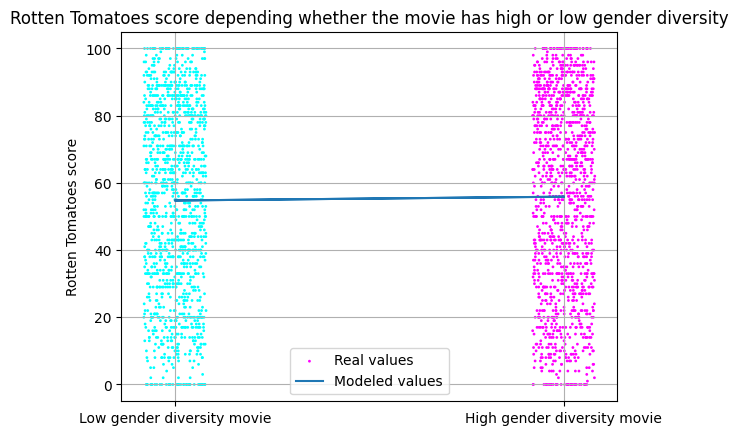

In [93]:
# Group the movies by Country, Genre and Discretized Year 
grouped = obsDF.dropna(subset=['discrete_gender_diversity', 'Rotten_Tomatoes_score']).groupby(['Discretized_Year','Genre','Country'], dropna=True)
gender_rotten_DF = exact_matching(grouped, 'discrete_gender_diversity')
print('length of the gender diversity matched dataset with Rotten Tomatoes scores: ', len(gender_rotten_DF))
res = smf.ols(formula='Rotten_Tomatoes_score ~ C(discrete_gender_diversity)', data=gender_rotten_DF).fit()
print(res.summary())

beta0_gender_rotten, beta1_gender_rotten = res.params.values

plt.scatter(gender_rotten_DF['discrete_gender_diversity']+ np.random.uniform(-0.08,0.08,len(gender_rotten_DF['discrete_gender_diversity'])), gender_rotten_DF['Rotten_Tomatoes_score'], label = "Real values",c=gender_rotten_DF['discrete_gender_diversity'], cmap='cool',s=1) 
plt.plot(gender_rotten_DF['discrete_gender_diversity'], beta0_gender_rotten + np.multiply(beta1_gender_rotten,gender_rotten_DF['discrete_gender_diversity']), label = "Modeled values")
plt.grid(True)
plt.title('Rotten Tomatoes score depending whether the movie has high or low gender diversity')
plt.ylabel('Rotten Tomatoes score')
plt.legend()
plt.xticks(ticks = np.arange(0, 2),labels = ['Low gender diversity movie', 'High gender diversity movie'])
plt.show()


length of the gender diversity matched dataset with Box office revenue:  1786
                              OLS Regression Results                             
Dep. Variable:     ln_Box_office_revenue   R-squared:                       0.014
Model:                               OLS   Adj. R-squared:                  0.014
Method:                    Least Squares   F-statistic:                     25.49
Date:                   Fri, 23 Dec 2022   Prob (F-statistic):           4.91e-07
Time:                           11:35:53   Log-Likelihood:                -2285.7
No. Observations:                   1786   AIC:                             4575.
Df Residuals:                       1784   BIC:                             4586.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975

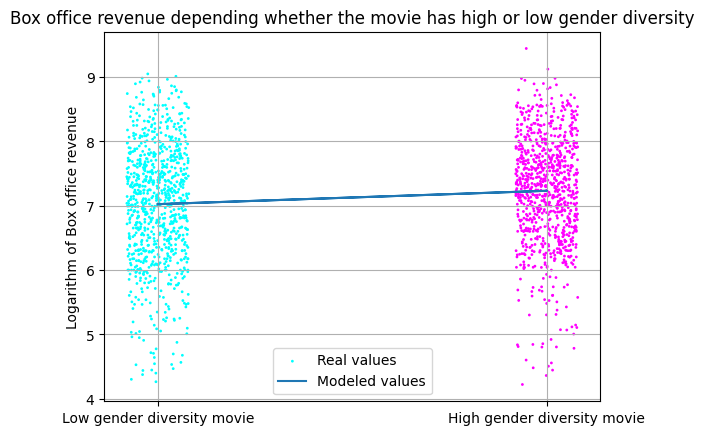

In [94]:
# Group the movies by Country, Genre and Discretized Year 
grouped = obsDF.dropna(subset=['discrete_gender_diversity', 'Box_office_revenue']).groupby(['Discretized_Year','Genre','Country'], dropna=True)
gender_box_DF = exact_matching(grouped, 'discrete_gender_diversity')
print('length of the gender diversity matched dataset with Box office revenue: ', len(gender_box_DF))

gender_box_DF['ln_Box_office_revenue'] = np.log10(gender_box_DF['Box_office_revenue'])
res = smf.ols(formula='ln_Box_office_revenue ~ C(discrete_gender_diversity)', data=gender_box_DF).fit()
print(res.summary())

beta0_gender_box, beta1_gender_box = res.params.values

plt.scatter(gender_box_DF['discrete_gender_diversity']+ np.random.uniform(-0.08,0.08,len(gender_box_DF['discrete_gender_diversity'])), gender_box_DF['ln_Box_office_revenue'], label = "Real values",c=gender_box_DF['discrete_gender_diversity'], cmap='cool',s=1) 
plt.plot(gender_box_DF['discrete_gender_diversity'], beta0_gender_box + np.multiply(beta1_gender_box,gender_box_DF['discrete_gender_diversity']), label = "Modeled values")
plt.grid(True)
plt.title('Box office revenue depending whether the movie has high or low gender diversity')
plt.ylabel('Logarithm of Box office revenue')
plt.legend()
plt.xticks(ticks = np.arange(0, 2),labels = ['Low gender diversity movie', 'High gender diversity movie'])
plt.show()

length of the ethnicity diversity matched dataset with Rotten Tomatoes score:  402
                              OLS Regression Results                             
Dep. Variable:     Rotten_Tomatoes_score   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.045
Date:                   Fri, 23 Dec 2022   Prob (F-statistic):              0.307
Time:                           11:35:55   Log-Likelihood:                -1886.8
No. Observations:                    402   AIC:                             3778.
Df Residuals:                        400   BIC:                             3786.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025   

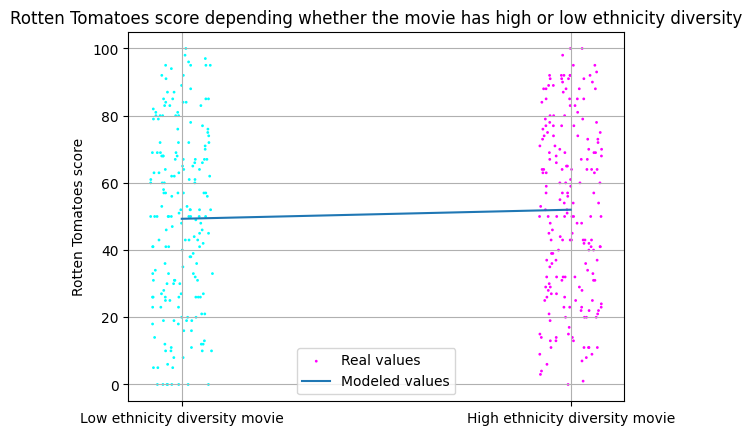

In [95]:
# Group the movies by Country, Genre and Discretized Year 
grouped = obsDF.dropna(subset=['discrete_ethnicity_diversity', 'Rotten_Tomatoes_score']).groupby(['Discretized_Year','Genre','Country'], dropna=True)
ethnicity_rotten_DF = exact_matching(grouped, 'discrete_ethnicity_diversity')
print('length of the ethnicity diversity matched dataset with Rotten Tomatoes score: ', len(ethnicity_rotten_DF))

res = smf.ols(formula='Rotten_Tomatoes_score ~ C(discrete_ethnicity_diversity)', data=ethnicity_rotten_DF).fit()
print(res.summary())

beta0_ethnicity_rotten, beta1_ethnicity_rotten = res.params.values

plt.scatter(ethnicity_rotten_DF['discrete_ethnicity_diversity']+ np.random.uniform(-0.08,0.08,len(ethnicity_rotten_DF['discrete_ethnicity_diversity'])), ethnicity_rotten_DF['Rotten_Tomatoes_score'], label = "Real values",c=ethnicity_rotten_DF['discrete_ethnicity_diversity'], cmap='cool',s=1) 
plt.plot(ethnicity_rotten_DF['discrete_ethnicity_diversity'], beta0_ethnicity_rotten + np.multiply(beta1_ethnicity_rotten,ethnicity_rotten_DF['discrete_ethnicity_diversity']), label = "Modeled values")
plt.grid(True)
plt.title('Rotten Tomatoes score depending whether the movie has high or low ethnicity diversity')
plt.ylabel('Rotten Tomatoes score')
plt.legend()
plt.xticks(ticks = np.arange(0, 2),labels = ['Low ethnicity diversity movie', 'High ethnicity diversity movie'])
plt.show()

length of the ethnicity diversity matched dataset with Box office revenue:  270
                              OLS Regression Results                             
Dep. Variable:     ln_Box_office_revenue   R-squared:                       0.009
Model:                               OLS   Adj. R-squared:                  0.005
Method:                    Least Squares   F-statistic:                     2.362
Date:                   Fri, 23 Dec 2022   Prob (F-statistic):              0.125
Time:                           11:35:57   Log-Likelihood:                -351.54
No. Observations:                    270   AIC:                             707.1
Df Residuals:                        268   BIC:                             714.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      

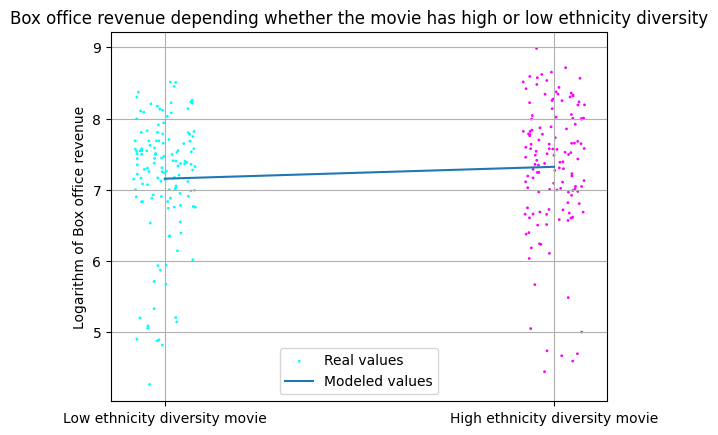

In [96]:
# Group the movies by Country, Genre and Discretized Year 
grouped = obsDF.dropna(subset=['discrete_ethnicity_diversity', 'Box_office_revenue']).groupby(['Discretized_Year','Genre','Country'], dropna=True)
ethnicity_box_DF = exact_matching(grouped, 'discrete_ethnicity_diversity')
print('length of the ethnicity diversity matched dataset with Box office revenue: ', len(ethnicity_box_DF))

ethnicity_box_DF['ln_Box_office_revenue'] = np.log10(ethnicity_box_DF['Box_office_revenue'])
res = smf.ols(formula='ln_Box_office_revenue ~ C(discrete_ethnicity_diversity)', data=ethnicity_box_DF).fit()
print(res.summary())

beta0_ethnicity_box, beta1_ethnicity_box = res.params.values

plt.scatter(ethnicity_box_DF['discrete_ethnicity_diversity']+ np.random.uniform(-0.08,0.08,len(ethnicity_box_DF['discrete_ethnicity_diversity'])), ethnicity_box_DF['ln_Box_office_revenue'], label = "Real values",c=ethnicity_box_DF['discrete_ethnicity_diversity'], cmap='cool',s=1) 
plt.plot(ethnicity_box_DF['discrete_ethnicity_diversity'], beta0_ethnicity_box + np.multiply(beta1_ethnicity_box,ethnicity_box_DF['discrete_ethnicity_diversity']), label = "Modeled values")
plt.grid(True)
plt.title('Box office revenue depending whether the movie has high or low ethnicity diversity')
plt.ylabel('Logarithm of Box office revenue')
plt.legend()
plt.xticks(ticks = np.arange(0, 2),labels = ['Low ethnicity diversity movie', 'High ethnicity diversity movie'])
plt.show()

### Plot generation

Generate plot for Rotten Tomatoes score vs. [Gender diversity score/Ethnicity diversity score]

In [97]:
fig = go.Figure()
mask_no_diversity = (gender_rotten_DF['discrete_gender_diversity']==0)
mask_diversity = gender_rotten_DF['discrete_gender_diversity']==1

#Add scatter for movie without GENDER diversity
fig.add_trace(go.Box(
                        y=gender_rotten_DF[mask_no_diversity]['Rotten_Tomatoes_score'],
                        text=gender_rotten_DF[mask_no_diversity]['Movie_name'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="Low gender score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Tomatometer Score: %{y}%",
                                        ])
                        ))
#Add scatter for movie WITH diversity
fig.add_trace(go.Box(
                        y=gender_rotten_DF[mask_diversity]['Rotten_Tomatoes_score'],
                        text=gender_rotten_DF[mask_diversity]['Movie_name'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="High gender score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Tomatometer Score: %{y}%",
                                        ]),
                        showlegend=True
                        ))



mask_no_diversity_ethnicity=ethnicity_rotten_DF['discrete_ethnicity_diversity']==0
mask_diversity_ethnicity=ethnicity_rotten_DF['discrete_ethnicity_diversity'] ==1

#Add scatter for movie without ETHNICITY diversity 
fig.add_trace(go.Box(
                        y=ethnicity_rotten_DF[mask_no_diversity_ethnicity]['Rotten_Tomatoes_score'],
                        text=ethnicity_rotten_DF[mask_no_diversity_ethnicity]['Movie_name'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="Low ethnicity score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Tomatometer Score: %{y}%",
                                        ]),
                        visible=False
                        ))
#Add scatter for movie WITH diversity
fig.add_trace(go.Box(
                        y=ethnicity_rotten_DF[mask_diversity_ethnicity]['Rotten_Tomatoes_score'],
                        text=ethnicity_rotten_DF[mask_diversity_ethnicity]['Movie_name'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="High ethnicity score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Tomatometer Score: %{y}%",
                                        ]),
                        showlegend=True,
                        visible=False
                        ))



fig.update_layout(title="Rotten Tomatoes score depending whether the <br>movie has high or low gender diversity")
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0,1],
        ticktext = ['Low diversity<br>movies', 'High diversity<br>movies']
    )
)

# Add dropdown
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Rotten Tomatoes vs Gender",
                     method="update",
                     args=[{"visible": [True, True,  False, False]},
                           {"title": "Rotten Tomatoes score depending whether the <br>movie has high or low gender diversity",
                            }]
                            ),
                dict(label="Rotten Tomatoes vs Ethnicity",
                     method="update",
                     args=[{"visible": [False, False, True, True]},
                           {"title": "Rotten Tomatoes score depending whether the <br>movie has high or low ethnicity diversity",
                            }])
                        ]),
            x=0, xanchor='left', y=1.39, yanchor='top'
            ),
    ])


fig.update_layout(yaxis_title="Rotten Tomatoes score")

#fig.update_layout(legend=dict(x=0.5,y=0.05,xanchor='center', yanchor='bottom'))
#fig.update_layout(legend=dict(x=0.5,y=1.,xanchor='center', yanchor='bottom'))
fig.update_layout(legend=dict(x=0.5,y=-0.25,xanchor='center', yanchor='bottom'))
fig.update_layout(margin=dict(t=100, b=0, l=0, r=0),)

fig.show()

fig.write_html("Plots/observational_Rotten_Score.html")


Generate plot for Box office revenue vs. [Gender diversity score/Ethnicity diversity score]

In [98]:
fig = go.Figure()
mask_no_diversity = (gender_box_DF['discrete_gender_diversity']==0)
mask_diversity = gender_box_DF['discrete_gender_diversity']==1

#Add scatter for movie without GENDER diversity
fig.add_trace(go.Box(
                        y=gender_box_DF[mask_no_diversity]['ln_Box_office_revenue'],
                        text=gender_box_DF[mask_no_diversity]['Movie_name'],
                        customdata=gender_box_DF[mask_no_diversity]['Box_office_revenue'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="Low gender score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Box office revenue: %{customdata} USD",
                                        ])
                        ))
#Add scatter for movie WITH diversity
fig.add_trace(go.Box(
                        y=gender_box_DF[mask_diversity]['ln_Box_office_revenue'],
                        text=gender_box_DF[mask_diversity]['Movie_name'],
                        customdata=gender_box_DF[mask_diversity]['Box_office_revenue'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="High gender score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Box office revenue: %{customdata} USD",
                                        ]),
                        showlegend=True
                        ))





mask_no_diversity_ethnicity=ethnicity_box_DF['discrete_ethnicity_diversity']==0
mask_diversity_ethnicity=ethnicity_box_DF['discrete_ethnicity_diversity'] ==1

#Add scatter for movie without ETHNICITY diversity 
fig.add_trace(go.Box(
                        y=ethnicity_box_DF[mask_no_diversity_ethnicity]['ln_Box_office_revenue'],
                        text=ethnicity_box_DF[mask_no_diversity_ethnicity]['Movie_name'],
                        customdata=ethnicity_box_DF[mask_no_diversity_ethnicity]['Box_office_revenue'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="Low diversity score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Box office revenue: %{customdata} USD",
                                        ]),
                        visible=False
                        ))
#Add scatter for movie WITH diversity
fig.add_trace(go.Box(
                        y=ethnicity_box_DF[mask_diversity_ethnicity]['ln_Box_office_revenue'],
                        text=ethnicity_box_DF[mask_diversity_ethnicity]['Movie_name'],
                        customdata=ethnicity_box_DF[mask_diversity_ethnicity]['Box_office_revenue'],
                        boxpoints='all',jitter=0.3, pointpos=-1.8,
                        name="High diversity score",
                        hovertemplate="<br>".join([
                                        "Movie: %{text}",
                                        "Box office revenue: %{customdata} USD",
                                        ]),
                        showlegend=True,
                        visible=False
                        ))




fig.update_layout(title="Box office revenue score depending whether the <br>movie has high or low gender diversity")
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0,1],
        ticktext = ['Low diversity<br>movies', 'High diversity<br> movies']
    )
)

# Add dropdown
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Box office vs Gender",
                     method="update",
                     args=[{"visible": [True, True, False, False]},
                           {"title": "Box office revenue depending whether the <br>movie has high or low gender diversity",
                            }]
                            ),
                dict(label="Box office vs Ethnicity",
                     method="update",
                     args=[{"visible": [False, False, True, True]},
                           {"title": "Box office revenue depending whether the <br>movie has high or low ethnicity diversity",
                            }])
                        ]),
            x=0, xanchor='left', y=1.39, yanchor='top'
            ),
    ])


fig.update_layout(yaxis_title="Logarithm of box office revenue")
#fig.update_layout(legend=dict(x=1,y=0.,xanchor='right', yanchor='bottom'))
#fig.update_layout(legend=dict(x=0.5,y=1.,xanchor='center', yanchor='bottom'))
fig.update_layout(legend=dict(x=0.5,y=-0.25,xanchor='center', yanchor='bottom'))

fig.update_layout(margin=dict(t=100, b=0, l=0, r=0),)
#fig.update_layout(xaxis_tickangle=-45)
fig.show()
fig.write_html("Plots/observational_Box_office.html")


## Propensity score matching for a yearly observational study 

Here, we want to analyze how the preferences between low and high diversity movies have evolved in time. Therefore, the matching is only done among data that have been produced during the same year. 


As we only match movies among a given year, we don't have much data. An exact matching would remove even more data so we have opted for a propensity score matching. 

We first compute the propensity score as follow: 
*discrete_gender_diversity ~ C(United_States_of_America) + C(United_Kingdom) + C(India) + C(France) + C(Italy) + C(Canada) + C(Germany) + C(Japan) + C(Argentina) + C(Spain) + C(Australia) + C(Hong_Kong) + C(South_Korea) + C(Drama) + C(Comedy) + C(Romance_Film) + C(Black_and_white) + C(Action) + C(Thriller) + C(Short_Film) + C(World_cinema) + C(Crime_Fiction) + C(Indie) + C(Documentary) + C(Horror) + Year*
(NB: we do exactly the same for discrete_ethnicty_diversity). 

Once we have the propensity score, we use the library networkx to match movies that have a similar propensity score. 

Once the matching is done, we will analyze the difference of rotten score and box office revenue between the high and low diversity group.
We will then be able to plot the evolution of this difference through time. 

We have only considered movies realised between 1990 and 2010 because we don't have enough data before and after. 

To get even more data, we will pool together movies that have been produced during [year-1, year+1] for gender score (we take 3 years together). 
And for ethnicity score, we pool movies that have been produced during [year-2, year+2] (we take 5 years together). We need to take a bigger margin for the ethnicity score because we have less data there. 




In [99]:
#create indicator variable 
for el in unique_genres:
    obsDF[el] = obsDF.Genre.apply(lambda g: el in g)

#create indicator variable 
for el in unique_countries:
    obsDF[el] = obsDF.Country.apply(lambda c: el in c)

#remove the space and the -. If we don't do this, smf gets very angry in the regression of the next cell
unique_genres = [el.replace("-","_").replace(" ","_") for el in unique_genres]
unique_countries = [el.replace("-","_").replace(" ","_") for el in unique_countries]

#remove the space and the - in the name of columns
obsDF.columns = obsDF.columns.str.replace(" ","_")
obsDF.columns = obsDF.columns.str.replace("-","_")

In [100]:
#this cell computes the propensity score of ethnicty score and gender score

country_formula = ""
for country in unique_countries:
    country_formula += "C("+country+") + "
country_formula=country_formula[0:-3]

#print(country_formula)

genre_formula = ""
for genre in unique_genres:
    genre_formula += "C("+genre+") + "
genre_formula=genre_formula[0:-3]

#print(genre_formula)

#remove the rows with empty year
obsDF = obsDF.dropna(subset=['Year'])

obsDF_gender = obsDF.dropna(subset=['discrete_gender_diversity'])

formula = 'discrete_gender_diversity ~ '+ country_formula+' + '+genre_formula+' + Year'

print("Computing the propensity score fot the gender diversity metric:")
print(formula)

model = smf.logit(formula, data=obsDF_gender).fit()

#view model summary
print(model.summary())

obsDF_gender['propensity_gender'] = model.predict()

obsDF_ethnicity =  obsDF.dropna(subset=['discrete_ethnicity_diversity'])

formula = 'discrete_ethnicity_diversity ~ '+ country_formula+' + '+genre_formula+' + Year'

print("Computing the propensity score fot the ethnicity diversity metric:")
print(formula)

model = smf.logit(formula, data=obsDF_ethnicity).fit()

#view model summary
print(model.summary())

obsDF_ethnicity['propensity_ethnicity'] = model.predict()


Computing the propensity score fot the gender diversity metric:
discrete_gender_diversity ~ C(United_States_of_America) + C(United_Kingdom) + C(India) + C(France) + C(Italy) + C(Canada) + C(Germany) + C(Japan) + C(Argentina) + C(Spain) + C(Australia) + C(Hong_Kong) + C(South_Korea) + C(Drama) + C(Comedy) + C(Romance_Film) + C(Black_and_white) + C(Action) + C(Thriller) + C(Short_Film) + C(World_cinema) + C(Crime_Fiction) + C(Indie) + C(Documentary) + C(Horror) + Year
Optimization terminated successfully.
         Current function value: 0.622407
         Iterations 5
                               Logit Regression Results                              
Dep. Variable:     discrete_gender_diversity   No. Observations:                15692
Model:                                 Logit   Df Residuals:                    15665
Method:                                  MLE   Df Model:                           26
Date:                       Fri, 23 Dec 2022   Pseudo R-squ.:                  0.10

In [101]:
propensity_matching_path = Path('/work/processedData/propensity_matching_effect.npz')

#check if the propensity matching has already been computed and stored
if propensity_matching_path.is_file():

    print("Propensity matching already done （‐＾▽＾‐）")
    propensity_matching_done = True

    propensity_matching = np.load(propensity_matching_path)

    #display the name and size of the stored array
    for name in propensity_matching:
       print("name:", name, "| array length:", len(propensity_matching[name]))

else: 
    propensity_matching_done = False

Propensity matching already done （‐＾▽＾‐）
name: year_values | array length: 21
name: effect_gender_rotten | array length: 21
name: effect_gender_box | array length: 21
name: effect_ethnicity_rotten | array length: 21
name: effect_ethnicity_box | array length: 21


In [102]:
if propensity_matching_done:
    year_values = propensity_matching["year_values"]

else:
    start_year = 1990
    end_year = 2010

    #this is the number of year before and after "year" that will be taken into account (moving average principle)
    moving_avg = 1

    year_values=[]

    for year in range(start_year,end_year+1):
            year_values.append(year)

    year_values = np.array(year_values)


In [103]:
if propensity_matching_done:
    effect_gender_rotten = propensity_matching["effect_gender_rotten"]

else:
    print("computing the effect of gender diversity on the Rotten Tomatoes score ")
    effect_gender_rotten=[]

    for year in range(start_year,end_year+1):

        tempDF = obsDF_gender[(obsDF_gender.Year>=year-moving_avg) & (obsDF_gender.Year<=year+moving_avg)]
        tempDF = tempDF.dropna(subset=['discrete_gender_diversity', 'Rotten_Tomatoes_score']).reset_index(drop=True)

        #Separate the group with diversity and teh group without
        diversitydf = tempDF[tempDF['discrete_gender_diversity'] == 1]
        nodiversitydf = tempDF[tempDF['discrete_gender_diversity'] == 0]

        # Create an empty graph
        G = nx.Graph()

        # Loop through all the pairs of instances
        for diversity_id, diversity_row in diversitydf.iterrows():
            for nodiversity_id, nodiversity_row in nodiversitydf.iterrows():

                # Calculate the similarity 
                similarity = 1-np.abs(diversity_row['propensity_gender']-nodiversity_row['propensity_gender'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(diversity_id, nodiversity_id, similarity)])

        # Generate and return the maximum weight matching on the generated graph
        matching = nx.max_weight_matching(G)

        #create the matched DF with the indexes we just found
        matchedindex = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

        matchedDF = tempDF.iloc[matchedindex]

        #the effect characterize the difference of the mean of the rotten tomatoes score between high and low diversity movies 
        effect = matchedDF[matchedDF['discrete_gender_diversity'] == 1].Rotten_Tomatoes_score.mean() - matchedDF[matchedDF['discrete_gender_diversity'] == 0].Rotten_Tomatoes_score.mean()

        print("Year: "+str(year)+", number of movie: "+str(len(tempDF))+", number of matched movies: "+str(len(matchedDF))+", effect is: "+str(effect))
        
        effect_gender_rotten.append(effect)

    effect_gender_rotten = np.array(effect_gender_rotten)

In [104]:
if propensity_matching_done:
    effect_gender_box = propensity_matching["effect_gender_box"]

else:
    print("computing the effect of gender diversity on the (logarithm of the) Box office revenue ")
    effect_gender_box=[]

    for year in range(start_year,end_year+1):

        tempDF = obsDF_gender[(obsDF_gender.Year>=year-moving_avg) & (obsDF_gender.Year<=year+moving_avg)]
        tempDF = tempDF.dropna(subset=['discrete_gender_diversity', 'Box_office_revenue']).reset_index(drop=True)
        tempDF['log_box'] = np.log10(tempDF['Box_office_revenue'])

        #Separate the group with diversity and teh group without
        diversitydf = tempDF[tempDF['discrete_gender_diversity'] == 1]
        nodiversitydf = tempDF[tempDF['discrete_gender_diversity'] == 0]

        # Create an empty graph
        G = nx.Graph()

        # Loop through all the pairs of instances
        for diversity_id, diversity_row in diversitydf.iterrows():
            for nodiversity_id, nodiversity_row in nodiversitydf.iterrows():

                # Calculate the similarity 
                similarity = 1-np.abs(diversity_row['propensity_gender']-nodiversity_row['propensity_gender'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(diversity_id, nodiversity_id, similarity)])

        # Generate and return the maximum weight matching on the generated graph
        matching = nx.max_weight_matching(G)

        #create the matched DF with the indexes we just found
        matchedindex = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

        matchedDF = tempDF.iloc[matchedindex]

        #the effect characterize the difference of the mean of the log(box office revenue) between high and low diversity movies 
        effect = matchedDF[matchedDF['discrete_gender_diversity'] == 1].log_box.mean() - matchedDF[matchedDF['discrete_gender_diversity'] == 0].log_box.mean()

        print("Year: "+str(year)+", number of movie: "+str(len(tempDF))+", number of matched movies: "+str(len(matchedDF))+", effect is: "+str(effect))
        
        effect_gender_box.append(effect)

    effect_gender_box = np.array(effect_gender_box)

In [105]:
#for the ethnicity score, we leed a larger moving average as there is less data per year 
moving_avg = 2

In [106]:
if propensity_matching_done:
    effect_ethnicity_rotten = propensity_matching["effect_ethnicity_rotten"]

else:
    print("computing the effect of gender diversity on the Rotten Tomatoes score ")
    effect_ethnicity_rotten=[]

    for year in range(start_year,end_year+1):

        tempDF = obsDF_ethnicity[(obsDF_ethnicity.Year>=year-moving_avg) & (obsDF_ethnicity.Year<=year+moving_avg)]
        tempDF = tempDF.dropna(subset=['discrete_ethnicity_diversity', 'Rotten_Tomatoes_score']).reset_index(drop=True)

        #Separate the group with diversity and teh group without
        diversitydf = tempDF[tempDF['discrete_ethnicity_diversity'] == 1]
        nodiversitydf = tempDF[tempDF['discrete_ethnicity_diversity'] == 0]

        # Create an empty graph
        G = nx.Graph()

        # Loop through all the pairs of instances
        for diversity_id, diversity_row in diversitydf.iterrows():
            for nodiversity_id, nodiversity_row in nodiversitydf.iterrows():

                # Calculate the similarity 
                similarity = 1-np.abs(diversity_row['propensity_ethnicity']-nodiversity_row['propensity_ethnicity'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(diversity_id, nodiversity_id, similarity)])

        # Generate and return the maximum weight matching on the generated graph
        matching = nx.max_weight_matching(G)

        #create the matched DF with the indexes we just found
        matchedindex = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

        matchedDF = tempDF.iloc[matchedindex]

        #the effect characterize the difference of the mean of the rotten tomatoes score between high and low diversity movies         
        effect = matchedDF[matchedDF['discrete_ethnicity_diversity'] == 1].Rotten_Tomatoes_score.mean() - matchedDF[matchedDF['discrete_ethnicity_diversity'] == 0].Rotten_Tomatoes_score.mean()
        print("Year: "+str(year)+", number of movie: "+str(len(tempDF))+", number of matched movies: "+str(len(matchedDF))+", effect is: "+str(effect))
        
        effect_ethnicity_rotten.append(effect)

    effect_ethnicity_rotten = np.array(effect_ethnicity_rotten)

In [107]:
if propensity_matching_done:
    effect_ethnicity_box = propensity_matching["effect_ethnicity_box"]

else:
    print("computing the effect of ethnicity diversity on the (logarithm of the) Box office revenue ")
    effect_ethnicity_box=[]

    for year in range(start_year,end_year+1):

        tempDF = obsDF_ethnicity[(obsDF_ethnicity.Year>=year-moving_avg) & (obsDF_ethnicity.Year<=year+moving_avg)]
        tempDF = tempDF.dropna(subset=['discrete_ethnicity_diversity', 'Box_office_revenue']).reset_index(drop=True)
        tempDF['log_box'] = np.log10(tempDF['Box_office_revenue'])

        #Separate the group with diversity and teh group without
        diversitydf = tempDF[tempDF['discrete_ethnicity_diversity'] == 1]
        nodiversitydf = tempDF[tempDF['discrete_ethnicity_diversity'] == 0]

        # Create an empty graph
        G = nx.Graph()

        # Loop through all the pairs of instances
        for diversity_id, diversity_row in diversitydf.iterrows():
            for nodiversity_id, nodiversity_row in nodiversitydf.iterrows():

                # Calculate the similarity 
                similarity = 1-np.abs(diversity_row['propensity_ethnicity']-nodiversity_row['propensity_ethnicity'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(diversity_id, nodiversity_id, similarity)])

        # Generate and return the maximum weight matching on the generated graph
        matching = nx.max_weight_matching(G)

        #create the matched DF with the indexes we just found
        matchedindex = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

        matchedDF = tempDF.iloc[matchedindex]

        #the effect characterize the difference of the mean of the log(box office revenue) between high and low diversity movies 
        effect = matchedDF[matchedDF['discrete_ethnicity_diversity'] == 1].log_box.mean() - matchedDF[matchedDF['discrete_ethnicity_diversity'] == 0].log_box.mean()

        print("Year: "+str(year)+", number of movie: "+str(len(tempDF))+", number of matched movies: "+str(len(matchedDF))+", effect is: "+str(effect))
        
        effect_ethnicity_box.append(effect)

    effect_ethnicity_box = np.array(effect_ethnicity_box)

In [108]:
#save the data to a npz file
if propensity_matching_done == False:
    np.savez(propensity_matching_path, 
            year_values=year_values, 
            effect_gender_rotten=effect_gender_rotten,
            effect_gender_box=effect_gender_box, 
            effect_ethnicity_rotten=effect_ethnicity_rotten,
            effect_ethnicity_box=effect_ethnicity_box)

In [109]:
# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=year_values, y=effect_gender_rotten, 
                name="Gender diversity",
                #text=list(grouped_by_year['gender_diversity']['count']),
                hovertemplate="<br>".join([  
                                        "%{y:.3f}"
                                        ])))
fig.add_trace(
    go.Scatter(x=year_values, y=effect_ethnicity_rotten, 
                name="Ethnicity diversity" ,
                #text=list(grouped_by_year['ethnicity_diversity']['count']),
                hovertemplate="<br>".join([  
                                        "%{y:.3f}"
                                        ])))

# Set title
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Difference of Rotten Tomatoes score",
    #margin={"t":0},
    title={
        'text': "Difference of Rotten Tomatoes score between high and low diversity movies",
        'y':0.9,
        'x':0.09,
        'xanchor': 'left',
        'yanchor': 'top'}
)

fig.update_layout(hovermode="x unified")
fig.update_layout(xaxis_hoverformat='%Y')

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


fig.show()
fig.write_html("Plots/temporal_obsstudy_rotten.html")

In [110]:
# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=year_values, y=effect_gender_box, 
                name="Gender diversity",
                #text=list(grouped_by_year['gender_diversity']['count']),
                hovertemplate="<br>".join([  
                                        "%{y:.3f}"
                                        ])))
fig.add_trace(
    go.Scatter(x=year_values, y=effect_ethnicity_box, 
                name="Ethnicity diversity" ,
                #text=list(grouped_by_year['ethnicity_diversity']['count']),
                hovertemplate="<br>".join([  
                                        "%{y:.3f}"
                                        ])))

# Set title
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Difference of log(Box office revenue)",
    #margin={"b":10},
    title={
        'text': "Difference of log(Box office revenue) between high and low diversity movies",
        'y':0.9,
        'x':0.09,
        'xanchor': 'left',
        'yanchor': 'top'}
)

fig.update_layout(hovermode="x unified")
fig.update_layout(xaxis_hoverformat='%Y')

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


fig.show()
fig.write_html("Plots/temporal_obsstudy_box.html")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a711c6f0-6865-444e-9562-4b2303293cdf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>